# Business Problem

A empresa Top Bank atua na Europa tendo como principal produto uma conta bancária. Este produto pode manter o salário do cliente e efetuar pagamentos. Essa conta não tem nenhum custo nos primeiros 12 meses, porém, após esse período, o cliente precisa recontratar o banco para os próximos 12 meses e refazer esse processo todos os anos. Recentemente, a equipe de análise notou que a taxa de churn está aumentando.

## Challenge:
Como Cientista de Dados, você precisa criar um plano de ação para diminuir o número de clientes churn e mostrar o retorno financeiro da sua solução.
Além disso, você precisará fornecer um relatório relatando o desempenho de seu modelo e o impacto financeiro de sua solução.
Perguntas que o CEO e a equipe do Analytics gostariam de ver em seu relatório:

1. Qual é a atual taxa de churn do Top Bank?
2. Qual é o desempenho do modelo na classificação de clientes como churns?
3. Qual é o retorno esperado, em termos de receita, se a empresa utilizar seu modelo para evitar o churn de clientes?

## Note:
Como posso responder os 4 desafios do problema???

    R: Conhecer as variáveis (Data Description) e definir plano de desenvolvimento.

# Imports

In [1]:
#Data Processing
import pandas as pd
import numpy as np
from scipy import stats

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Data Preparation
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

#Feature Selection
from sklearn.model_selection import train_test_split
from boruta import BorutaPy

#Model and Metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score

#Parameter and Model Saving
import pickle

#Display Jupyter
from IPython.core.display import HTML
from IPython.core.display import Image
import warnings
warnings.filterwarnings('ignore')

## Helper Functions

In [2]:
binary_palette = []
sequencial_palette = ['#ffe14d', '#fac04b', '#f59f49', '#f08048', '#eb6246', '#e64545', '#e0435e', '#db4275', '#d6408b', '#d13fa0', '#cc3db4', '#c73cc7']
categorical_palette = ["#fbbd05", "#ff7a5c", "#ff4d4d", "#ff0000", "#c90000"]

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [16, 4]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = 50
    pd.options.display.max_rows= False
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    sns.set_palette(categorical_palette)
    
    
def numeric_descriptive_statistical(numeric_attributes):
    mean = pd.DataFrame(numeric_attributes.apply(np.mean)).T
    median = pd.DataFrame(numeric_attributes.apply(np.median)).T
    standard_deviation = pd.DataFrame(numeric_attributes.apply(np.std)).T
    minimum = pd.DataFrame(numeric_attributes.apply(np.min)).T
    maximum = pd.DataFrame(numeric_attributes.apply(np.max)).T
    distance_between_minimum_and_maximum = pd.DataFrame(numeric_attributes.apply(lambda x: x.max() - x.min())).T
    unique = pd.DataFrame(numeric_attributes.apply(lambda x: len(x.unique()))).T
    skewness = pd.DataFrame(numeric_attributes.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(numeric_attributes.apply(lambda x: x.kurtosis())).T
    

    #concatenate
    vizualizer_descriptive_statistical = pd.concat([minimum, maximum, distance_between_minimum_and_maximum, unique, mean, median, standard_deviation, skewness, kurtosis]).T.reset_index()
    vizualizer_descriptive_statistical.columns = ['Variáveis', 'Mínimo', 'Máximo', 'Range', 'Valores Únicos', 'Média', 'Mediana', 'Desv. Padrão', 'Assimetria', 'Curtose']

    return vizualizer_descriptive_statistical


def n_bins(numeric_column):
    n = numeric_column.shape[0]
    k = round(1 + (3.3 * np.log10(n)))    
        
    return k


def show_univariate_numeric_distribution(numeric_column, bins, title, ylabel, xlabel):
    # Get statistics
    min_val = numeric_column.min()
    max_val = numeric_column.max()
    mean_val = numeric_column.mean()
    med_val = numeric_column.median()
    mod_val = numeric_column.mode()[0]
    first_quartile_val= np.percentile(numeric_column, 25)
    third_quartile_val = np.percentile(numeric_column, 75)
    
    print('Mínimo:{:.2f}\nMédia:{:.2f}\nMediana:{:.2f}\nModa:{:.2f}\nMáximo:{:.2f}\nPrimeiro Quartil:{:.2f}\nTerceiro Quartil:{:.2f}'.format(min_val, mean_val,
                                                                                                                                             med_val, mod_val, max_val,
                                                                                                                                             first_quartile_val,
                                                                                                                                             third_quartile_val))

    # Create a figure for 2 subplots (2 rows, 1 column)
    fig, ax = plt.subplots(2, 1, figsize = (16,4))

    # Plot the histogram   
    ax[0].hist(numeric_column, bins= bins, color= 'salmon')
    ax[0].set_ylabel(ylabel)

    # Add lines for the mean, median, and mode
    ax[0].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=first_quartile_val, color = 'yellow', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mod_val, color = 'green', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=third_quartile_val, color = 'yellow', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)

    # Plot the boxplot   
    ax[1].boxplot(numeric_column, vert=False)
    ax[1].set_xlabel(xlabel)

    # Add a title to the Figure
    fig.suptitle(title)
    
    fig.show()
    
    return  None


def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1)*(r - 1)/(n - 1))
    
    kcorr = k - (k - 1)**2/(n - 1)
    rcorr = r - (r - 1)**2/(n - 1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Load Data

In [3]:
data_raw = pd.read_csv('../data/churn.csv')
data_raw

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


# Data Description

In [4]:
df2 = data_raw.copy()

## Meaning of Data

- **RowNumber**: o número das colunas
- **CustomerID**: identificador único de clientes
- **Surname**: sobrenome do cliente
- **CreditScore**: pontuação de crédito do cliente para o mercado financeiro (quanto maior o score, é um bom pagador)
- **Geography**: o país do cliente
- **Gender**: o gênero do cliente
- **Age**: a idade do cliente
- **Tenure**: número de anos que o cliente está no banco
- **Balance**: o valor que o cliente tem em sua conta
- **NumOfProducts**: o número de produtos que o cliente comprou (no caso, contas)
- **HasCrCard**: se o cliente tiver cartão de crédito
- **IsActiveMember**: se o cliente estiver ativo (nos últimos 12 meses)
- **EstimateSalary**: estimativa de salário anual dos clientes
- **Exited**: se o cliente for churn (*variável resposta*)

## Rename Columns

In [5]:
renamed_columns = ['numero_linha', 'id_cliente', 'sobrenome', 'score_credito', 'geografia', 'genero', 'idade', 'tempo_permanencia', 
                   'saldo', 'numero_de_contas', 'tem_cartao_credito', 'membro_ativo', 'salario_estimado', 'Churn']
df2.columns = renamed_columns

df2.head(1)

,numero_linha,id_cliente,sobrenome,score_credito,geografia,genero,idade,tempo_permanencia,saldo,numero_de_contas,tem_cartao_credito,membro_ativo,salario_estimado,Churn
0,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,101348.88,1


## Data Dimensions

In [6]:
data_dimensions = df2.shape
print(f'A base de dados possui {data_dimensions[0]} clientes e {data_dimensions[1]} variáveis.')

A base de dados possui 10000 clientes e 14 variáveis.


## Data Types

In [7]:
df2.dtypes

numero_linha            int64
id_cliente              int64
sobrenome              object
score_credito           int64
geografia              object
genero                 object
idade                   int64
tempo_permanencia       int64
saldo                 float64
numero_de_contas        int64
tem_cartao_credito      int64
membro_ativo            int64
salario_estimado      float64
Churn                   int64
dtype: object

### Change Data Types

In [8]:
#Alterando o tipo de dados das colunas binárias: 'tem_cartao_credito', 'membro_ativo' e 'Churn'
categorical_columns = ['tem_cartao_credito', 'membro_ativo', 'Churn']

for columns in categorical_columns:
    df2[columns] = df2[columns].apply(lambda x: 'yes' if x == 1 else 'no')
    
df2.dtypes

numero_linha            int64
id_cliente              int64
sobrenome              object
score_credito           int64
geografia              object
genero                 object
idade                   int64
tempo_permanencia       int64
saldo                 float64
numero_de_contas        int64
tem_cartao_credito     object
membro_ativo           object
salario_estimado      float64
Churn                  object
dtype: object

## Check Duplicates

In [9]:
df2[df2.duplicated('id_cliente', False)]

,numero_linha,id_cliente,sobrenome,score_credito,geografia,genero,idade,tempo_permanencia,saldo,numero_de_contas,tem_cartao_credito,membro_ativo,salario_estimado,Churn


- A base não possui dados duplicados.

## Check NaN and Null Values

In [10]:
#Dados NaN
df2.isna().sum()

numero_linha          0
id_cliente            0
sobrenome             0
score_credito         0
geografia             0
genero                0
idade                 0
tempo_permanencia     0
saldo                 0
numero_de_contas      0
tem_cartao_credito    0
membro_ativo          0
salario_estimado      0
Churn                 0
dtype: int64

In [11]:
#Dados Null
df2.isnull().sum()

numero_linha          0
id_cliente            0
sobrenome             0
score_credito         0
geografia             0
genero                0
idade                 0
tempo_permanencia     0
saldo                 0
numero_de_contas      0
tem_cartao_credito    0
membro_ativo          0
salario_estimado      0
Churn                 0
dtype: int64

- A base não possui dados faltantes.

## Check Zero Values

In [12]:
df2.dtypes

numero_linha            int64
id_cliente              int64
sobrenome              object
score_credito           int64
geografia              object
genero                 object
idade                   int64
tempo_permanencia       int64
saldo                 float64
numero_de_contas        int64
tem_cartao_credito     object
membro_ativo           object
salario_estimado      float64
Churn                  object
dtype: object

In [13]:
#Transfomando valores diferentes de 0 em "another value" em todas as variáveis numéricas
numerical_variables = df2.select_dtypes(include= ['int64', 'float64']).columns
numerical_variables_verify = df2[numerical_variables]

for column in numerical_variables_verify.columns:
    numerical_variables_verify[column] = numerical_variables_verify[column].apply(lambda x: '0' if x == 0 else 'another value')

In [14]:
numerical_variables_verify.apply(lambda x: x.unique())

numero_linha            [another value]
id_cliente              [another value]
score_credito           [another value]
idade                   [another value]
tempo_permanencia    [another value, 0]
saldo                [0, another value]
numero_de_contas        [another value]
salario_estimado        [another value]
dtype: object

- Apenas as variáveis 'tempo_permanencia' e 'saldo' possuem valores declarados como 0.

De fato, apenas as colunas 'score_credito' (dependendo da regra de negócio), 'tempo_permanencia' e 'saldo' fazem sentido terem valores iguais a 0, mas ainda cabe análise.

In [15]:
percentage_0_in_saldo = numerical_variables_verify['saldo'].value_counts()[1] / numerical_variables_verify.shape[0] * 100
percentage_0_in_tenure = numerical_variables_verify['tempo_permanencia'].value_counts()[1] / numerical_variables_verify.shape[0] * 100
print(f'A coluna \'saldo\' possui {percentage_0_in_saldo}% registros zerados')
print(f'A coluna \'tempo_permanencia\' possui {percentage_0_in_tenure:.2f}% registros zerados')

A coluna 'saldo' possui 36.17% registros zerados
A coluna 'tempo_permanencia' possui 4.13% registros zerados


### *saldo*

Text(0.5, 1.0, 'Clientes com Saldos Zerados')

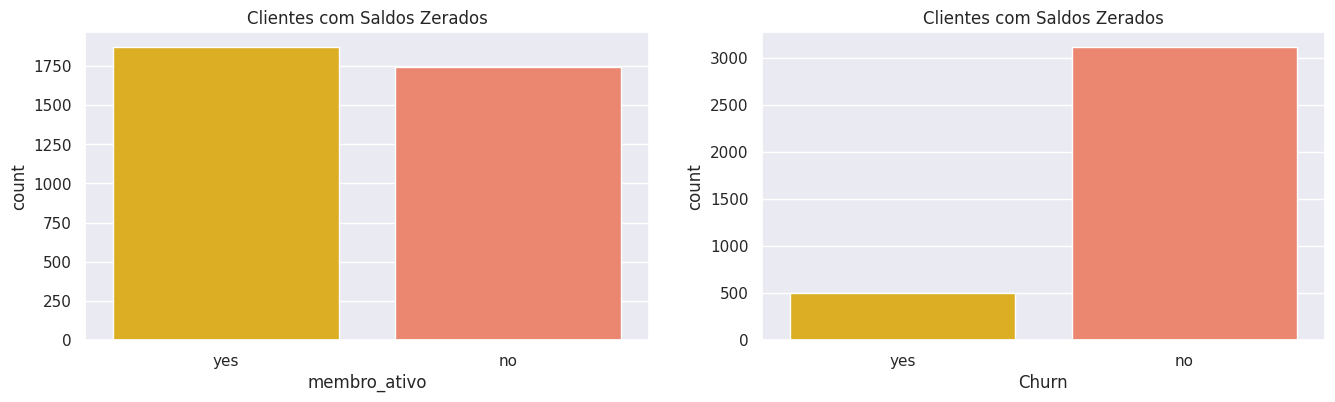

In [16]:
df_zero_balance = df2[['saldo', 'tempo_permanencia', 'membro_ativo', 'Churn']].loc[df2['saldo'] == 0]

plt.subplot(1, 2, 1)
sns.countplot(x= df_zero_balance['membro_ativo']);
plt.title("Clientes com Saldos Zerados")

plt.subplot(1, 2, 2)
sns.countplot(x= df_zero_balance['Churn']);
plt.title("Clientes com Saldos Zerados")

In [17]:
df_aux = df_zero_balance[['saldo', 'tempo_permanencia']].groupby('tempo_permanencia').count()
df_aux2 = df_zero_balance[['saldo', 'tempo_permanencia']].groupby('tempo_permanencia').count() / df_zero_balance.shape[0]

pd.concat([df_aux, df_aux2], axis= 1, keys= ['saldo_abs', 'saldo_perc'])

,saldo_abs,saldo_perc
,saldo,saldo
tempo_permanencia,,
0,137,0.037877
1,349,0.096489
2,382,0.105612
3,352,0.097318
4,369,0.102018
5,374,0.103401
6,367,0.101465
7,386,0.106718


In [18]:
mean = round(df_zero_balance['tempo_permanencia'].mean(), 2)
print(f'A média do tempo de permanência para contas com saldo zerado é de {mean} anos')

A média do tempo de permanência para contas com saldo zerado é de 5.07 anos


### 'tempo_de_permanencia' zerados:

**Suposição principal**: Como o conjunto de dados não possui dados temporais e registros zerados representam um pequena parte dos dados, vamos assumir que valores zerados nessa variável representam clientes que ainda não possuem 1 ano de empresa.

### 'saldo' zerados:

    1. praticamente se divide igualmentente em membros ativos e não ativos;
    2. de 3617 saldos zerados, apenas 500 são de clientes que irão dar Churn
    3. a média do tempo de permanência para contas com saldo zerado é de 5 anos
    4. a menor frequência de saldos zerados, são para clientes que adquiriram o em menos de 1 ano.

Logo é possível determinar:

    - saldos zerados não siginificam que são de contas pré criadas (obs. 4)
    - saldos zerados não possuem relação clara com membros ativos e inativos.
    
**Suposição principal**: Ignorar os questionamentos levantados na V1. Saldos zerados, representam de fato, contas sem capital disponível.

## Note:
Observações importantes:

Como não existe variável temporal, identificando o momento da extração dos dados, nasce alguns questionamentos:

	1. Qual ponto no tempo a extração de dados foi feita? Qual é a relevância desse período?

	2. Se os dados foi extraído como o resumo de 1 ano, o valor de saldo representa o valor presente na conta(s) no momento da extração, o somátorio de saldo presente na(s) conta(s) durante 1 ano ou o valor máximo do saldo presente nesse período.

	3. A variável Churn significa que o cliente de fato saiu da empresa ou possui a vontade de sair. Pois se o cliente de fato saiu da empresa, existe clientes que saíram do banco, mas que ainda possuiam saldo em sua(s) conta(s).

	4. O que seria de fato 'membro_ativo', clientes que fizeram transações em todos os meses do ano, ou pelo menos uma vez durante o período de extração?

Pra esse projeto, irei modelar sem a resposta dessas questões, embora, ter o contexto melhora o entendimento do problema e possivelmente melhores resultados na modelagem dos dados.


Solução do problema de negócio:
    
1. Qual é a atual taxa de Churn do Top Bank?

        S: Análise Univariada da variável resposta 'Churn' > plotar gráfico de barras de churns e não-churns e printar porcentagem da relação das classes (concluído)


2. Como a taxa de churn varia mensalmente?

        S: Pela descrição dos dados já é possível avaliar que não existe uma variável temporal no conjunto de dados, mas a variável 'membro_ativo' e 'tempo_permanencia' está associada com a atividade durante um período de tempo, logo é possível tentar buscar uma correlação para tentar responder a segunda questão de negócio. (pendente)
        
3. Qual é o desempenho do modelo na classificação de clientes como churns?

        S: Criar modelo de classificação com as variáveis selecionadas por relevância (Análise Bivariada) e pelo Boruta. (em progresso)
        
4. Qual é o retorno esperado, em termos de receita, se a empresa utilizar seu modelo para evitar o churn de clientes?

        S: Com o modelo criado, é possível estimar o retorno esperado, criando casos de deduções sobre os salários de cada cliente. (pendente)

# Feature Engineering I (Creation of New Variables)

In [19]:
df3 = df2.copy()

In [20]:
#Escala FICO
df3['escala_fico'] = df3['score_credito'].apply(lambda x: 'too bad' if x < 580 else 'bad' if x < 670 else 'good' if x < 740 else 'very good' if x < 800 else 'excellent')

In [21]:
#LTV Médio (o quanto de receita o cliente representa para o negócio durante um determinado período de tempo)
	#fórmula: valor mensal da assinatura de conta (US$20,00) X numero de contas X tempo de permanencia (anos) X 12 meses
    
df3['LTV_medio'] = df3.apply(lambda x: round(x['numero_de_contas'] * x['tempo_permanencia'] * 12 , 2), axis= 1)


# Exploratory Data Analysis

In [22]:
df4 = df3.copy()

## Defining Variables for Analysis

In [23]:
#Response Variable
response_variable = df4['Churn']

#Numeric Variables
numeric_attributes = df4.select_dtypes(include= ['int64', 'float64'])

#Categorical Variables
categorical_attributes = df4.select_dtypes(exclude= ['int64', 'float64'])

## Univariate Analysis

### Response Variable

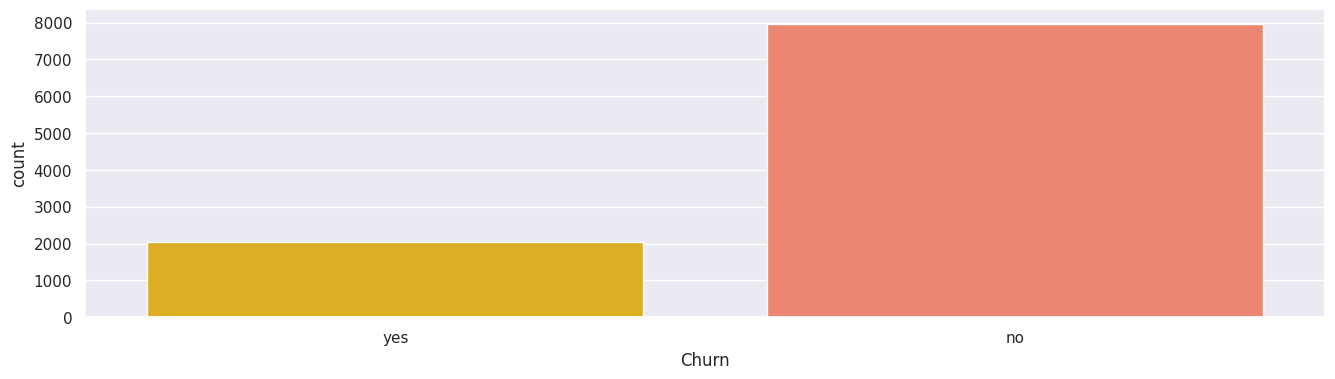

In [24]:
sns.countplot(x= response_variable);

In [25]:
percentage_no_churn = df4[['id_cliente', 'Churn']].loc[df4['Churn'] == 'no'].shape[0] / df4.shape[0] * 100
percentage_yes_churn = df4[['id_cliente', 'Churn']].loc[df4['Churn'] == 'yes'].shape[0] / df4.shape[0] * 100
print(f'Clientes que irão dar Churn correspondem a {percentage_yes_churn:.2f}%  da base de dados e clientes que não irão dar Churn correspondem a {percentage_no_churn:.2f}% da base de dados.')

Clientes que irão dar Churn correspondem a 20.37%  da base de dados e clientes que não irão dar Churn correspondem a 79.63% da base de dados.


- É evidente que a variável resposta possui classes desbalanceadas

### Numeric Variables

In [26]:
numeric_attributes.drop(columns= ['numero_linha', 'id_cliente'], inplace= True)
numeric_descriptive_statistical(numeric_attributes)

,Variáveis,Mínimo,Máximo,Range,Valores Únicos,Média,Mediana,Desv. Padrão,Assimetria,Curtose
0,score_credito,350.00,850.00,500.00,460.0,650.528800,652.000,96.648466,-0.071607,-0.425726
1,idade,18.00,92.00,74.00,70.0,38.921800,37.000,10.487282,1.011320,1.395347
2,tempo_permanencia,0.00,10.00,10.00,11.0,5.012800,5.000,2.892030,0.010991,-1.165225
3,saldo,0.00,250898.09,250898.09,6382.0,76485.889288,97198.540,62394.285254,-0.141109,-1.489412
4,numero_de_contas,1.00,4.00,3.00,4.0,1.530200,1.000,0.581625,0.745568,0.582981
5,salario_estimado,11.58,199992.48,199980.90,9999.0,100090.239881,100193.915,57507.617221,0.002085,-1.181518
6,LTV_medio,0.00,480.00,480.00,25.0,92.318400,84.000,66.978786,1.014525,1.272033


- **Muitos valores distintos**: *score_credito, idade, saldo, salário estimado, LTV_medio*.
- **Poucos valores distintos**: *tempo_permanencia, numero_de_contas*;

#### *score_credito*

Mínimo:350.00
Média:650.53
Mediana:652.00
Moda:850.00
Máximo:850.00
Primeiro Quartil:584.00
Terceiro Quartil:718.00


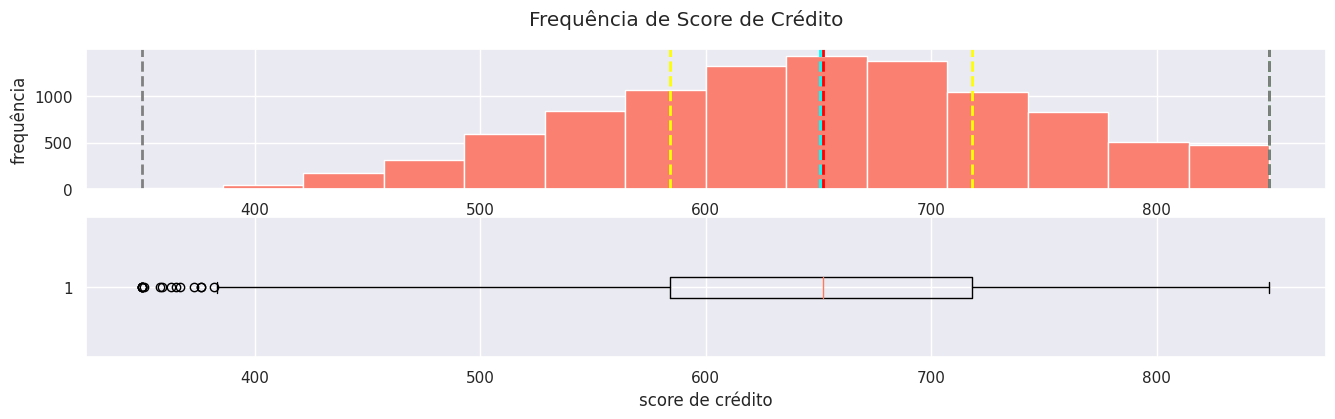

In [27]:
column = numeric_attributes['score_credito']
bins = n_bins(column)
title = "Frequência de Score de Crédito"
ylabel = "frequência"
xlabel = "score de crédito"
show_univariate_numeric_distribution(column, bins= bins, title= title, ylabel= ylabel, xlabel= xlabel)

In [28]:
#Note: 
	# segundo os intervalos de scores de crédito da FICO:
    	# 300 - 580: muito baixo;
        # 580 - 670: baixo;
        # 670 - 740: bom;
        # 740 - 800: muito bom;
        # 800 - 850: excelente;
        
    # é possível observar outliers para scores que se aproximam do valor mínimo (350) através do boxplot, mas com a curtose em -0.42 indicando que a distribuição tem uma pequena chance de ocorrência de
#outliers, logo o banco possui pouquíssimos clientes se aproximando do mínimo score_permitido pelo banco (aproximadamente uns 10).
    # a moda é igual ao valor máximo, o que pode evidênciar que o banco possui um grupo seleto de cliente que são bons pagadores. (vale criação de caso para esse grupo)
    # com assimetria em -0.07 evidencia que a distribuição de score está um pouco assimétrica à esquerda, logo existe uma maior concentração de valores na zona de valores mais elevados da amostra.
    # hipótese: 'clientes que são bons pagadores, possuem o salário mais alto?' ou 'clentes que possuem salários altos, são bons pagadores?'

#### *idade*

Mínimo:18.00
Média:38.92
Mediana:37.00
Moda:37.00
Máximo:92.00
Primeiro Quartil:32.00
Terceiro Quartil:44.00


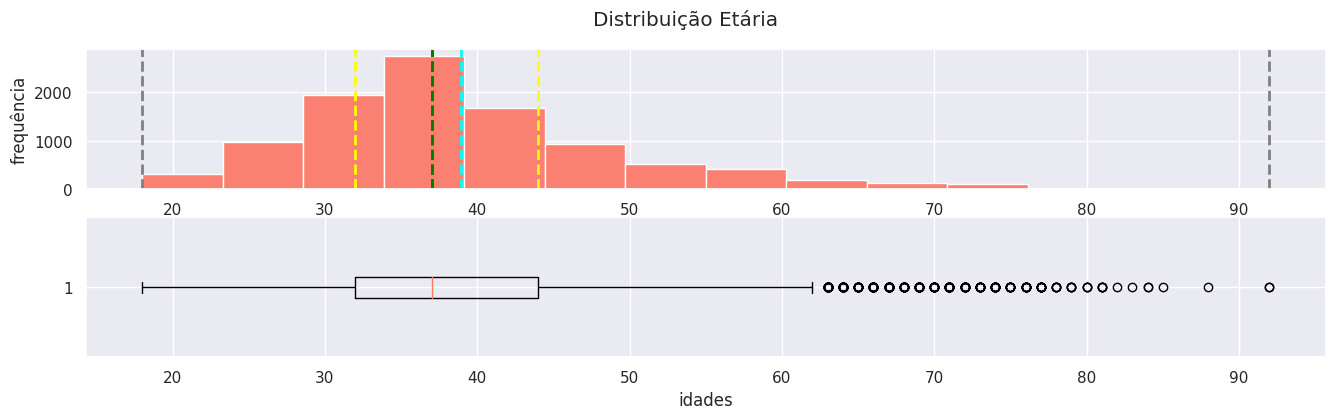

In [29]:
column = numeric_attributes['idade']
bins = n_bins(column)
title = "Distribuição Etária"
ylabel = "frequência"
xlabel = "idades"
show_univariate_numeric_distribution(column, bins= bins, title= title, ylabel= ylabel, xlabel= xlabel)

In [30]:
#Note
    # com a curtose positiva em 1.39 indica uma grande chance de existir outliers, evidenciado pelo boxplot que existe outlier para idade maiores de 62 anos. 
    # a mediana = moda > média, junto com a assimetria  em 1.011, evidencia que a distribuição de idade é assimétrica à direita, possuindo maior concentração de valores na zona de valores mais reduzida da amostra. 

#### *saldo*

Mínimo:0.00
Média:76485.89
Mediana:97198.54
Moda:0.00
Máximo:250898.09
Primeiro Quartil:0.00
Terceiro Quartil:127644.24


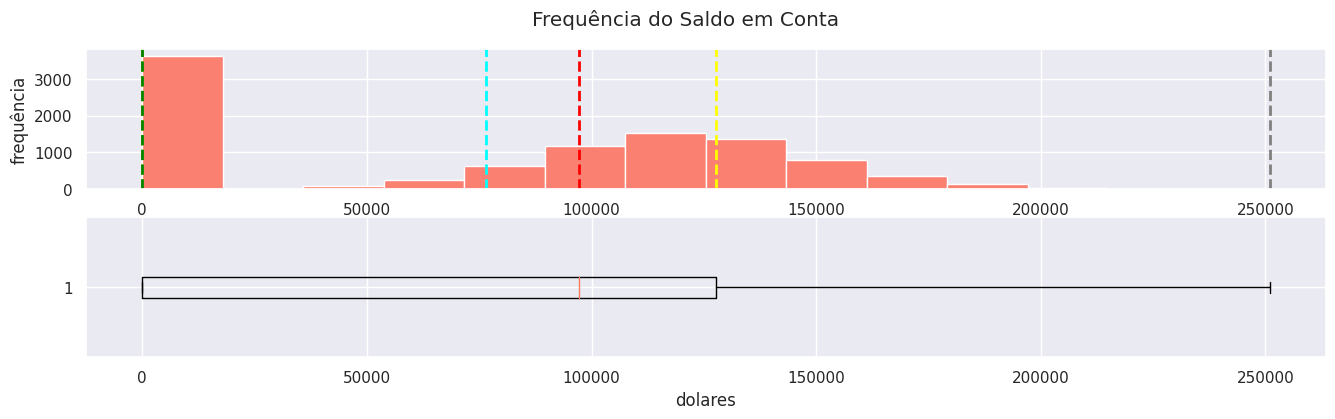

In [31]:
column = numeric_attributes['saldo']
bins = n_bins(column)
title = "Frequência do Saldo em Conta"
ylabel = "frequência"
xlabel = "dolares"
show_univariate_numeric_distribution(column, bins= bins, title= title, ylabel= ylabel, xlabel= xlabel)

In [32]:
#Note
	# com a curtose negativa, evidencia que existe uma pequena possibilidade de haver outliers. já o boxplot afirma que não existe outliers nesse conjunto.
    # com assimetria em -0.14, evidencia que a distribuição de score está um pouco assimétrica à esquerda, logo existe uma maior concentração de valores na zona de valores mais elevados da amostra,
#por mais que exista uma alta concentração de dados com valores 0, mostrado no gráfico e abordado na checagem de valores zerados.
	# mais de 36% dos clientes possuem contas zeradas.

#### *salario_estimado*

Mínimo:11.58
Média:100090.24
Mediana:100193.91
Moda:24924.92
Máximo:199992.48
Primeiro Quartil:51002.11
Terceiro Quartil:149388.25


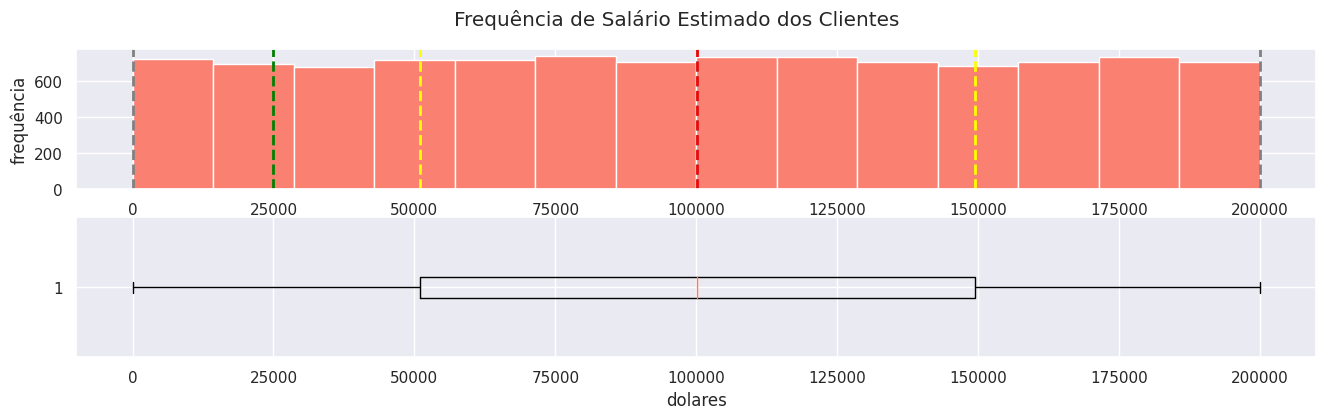

In [33]:
column = numeric_attributes['salario_estimado']
bins = n_bins(column)
title = "Frequência de Salário Estimado dos Clientes"
ylabel = "frequência"
xlabel = "dolares"
show_univariate_numeric_distribution(column, bins= bins, title= title, ylabel= ylabel, xlabel= xlabel)

In [34]:
#Note:
	# a distribuição dos salários é praticamente simétrica (evidenciado pelo valor da assimetria e pelos gráficos acima).
    # a distribuição dos salários também possui pouca chance de possuir valores dispersos, outliers (evidenciado pelo valor negativo da curtose e pelos gráficos acima).

#### *LTV_medio*

Mínimo:0.00
Média:92.32
Mediana:84.00
Moda:48.00
Máximo:480.00
Primeiro Quartil:48.00
Terceiro Quartil:120.00


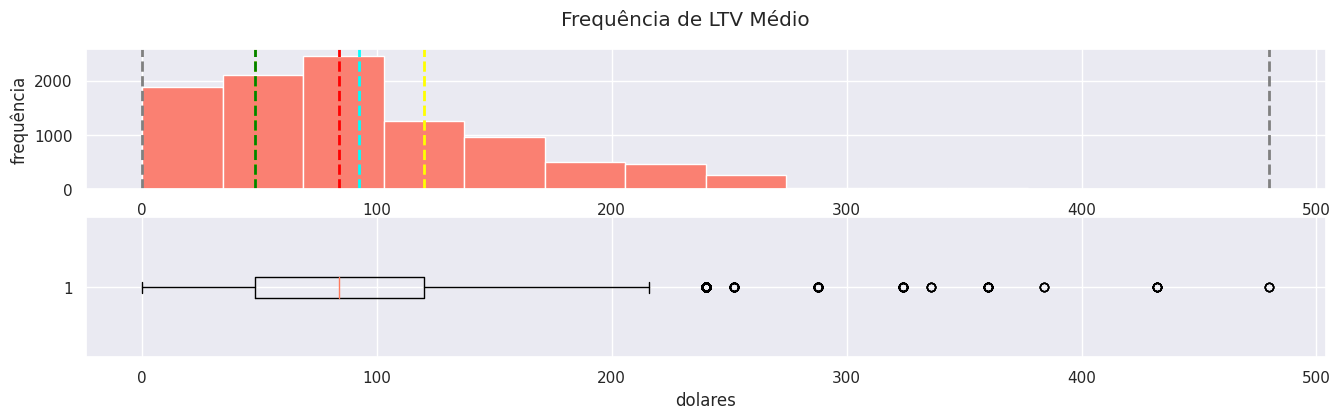

In [35]:
column = numeric_attributes['LTV_medio']
bins = n_bins(column)
title = "Frequência de LTV Médio"
ylabel = "frequência"
xlabel = "dolares"
show_univariate_numeric_distribution(column, bins= bins, title= title, ylabel= ylabel, xlabel= xlabel)

In [36]:
#Note:
    # com a curtose positiva, indica uma grande chance de existir outliers. evidenciado pelo boxplot, existe outliers para LTVs maiores que 4560 dolares. logo existe outliers consideráveis na zona
#de valores mais elevado da amostra.
    # com a assimetria positiva, evidencia que a distribuição de LTV está um pouco assimétrica à direita, logo existe uma maior concentração de valores na zona de valores mais reduzidos da amostra.
    # a moda = primeiro quartil.

#### *tempo_permanencia*

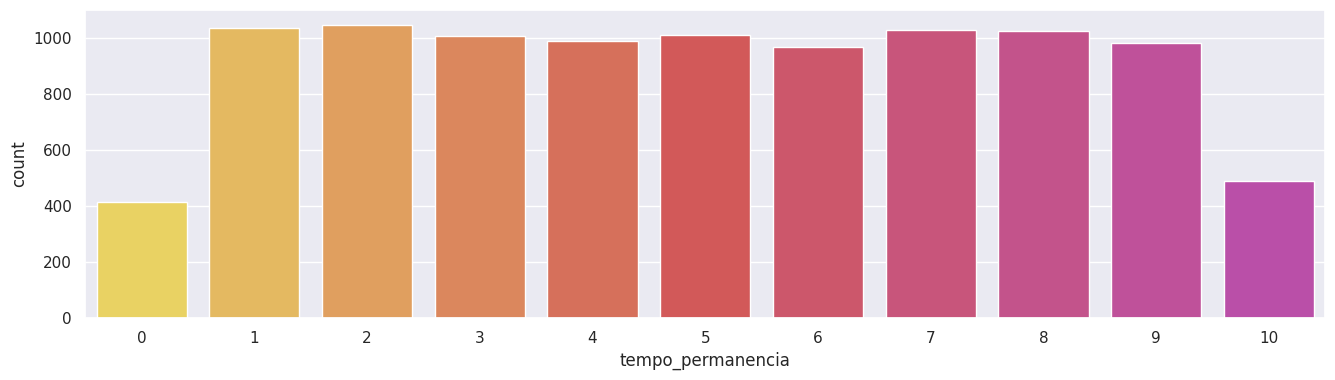

In [37]:
sns.countplot(x= df4['tempo_permanencia'], palette= sequencial_palette);

In [38]:
pd.DataFrame({'absoluto': df4['tempo_permanencia'].value_counts(), 'percentual (%)': df4['tempo_permanencia'].value_counts(normalize= True) * 100})

,absoluto,percentual (%)
2,1048,10.48
1,1035,10.35
7,1028,10.28
8,1025,10.25
5,1012,10.12
3,1009,10.09
4,989,9.89
9,984,9.84
6,967,9.67
10,490,4.90


#### *numero_de_contas*

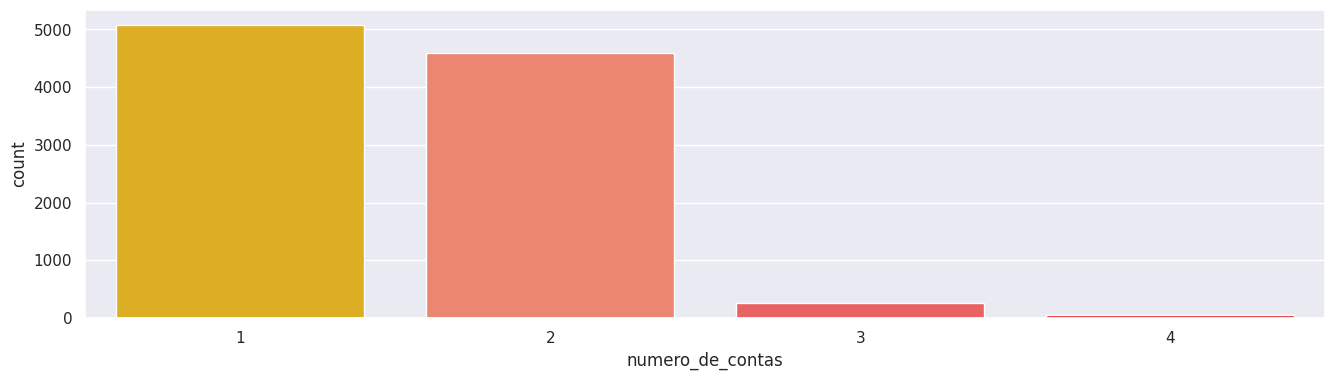

In [39]:
sns.countplot(x= df4['numero_de_contas']);

In [40]:
pd.DataFrame({'absoluto': df4['numero_de_contas'].value_counts(), 'percentual (%)': df4['numero_de_contas'].value_counts(normalize= True) * 100})

,absoluto,percentual (%)
1,5084,50.84
2,4590,45.90
3,266,2.66
4,60,0.60


### Categorical Variables

#### *geografia*

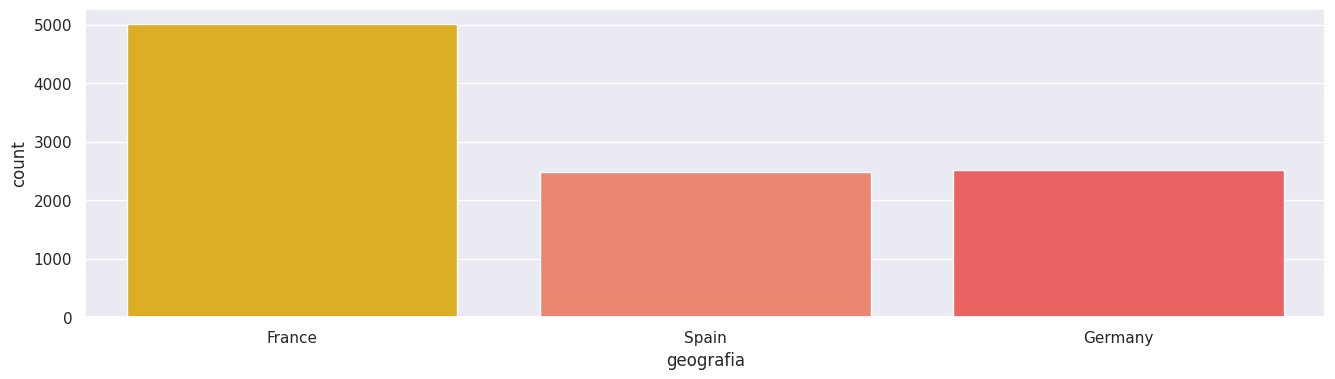

In [41]:
sns.countplot(x= df4['geografia'], palette= categorical_palette);

In [42]:
pd.DataFrame({'absoluto': df4['geografia'].value_counts(), 'percentual (%)': df4['geografia'].value_counts(normalize= True) * 100})

,absoluto,percentual (%)
France,5014,50.14
Germany,2509,25.09
Spain,2477,24.77


#### *genero*

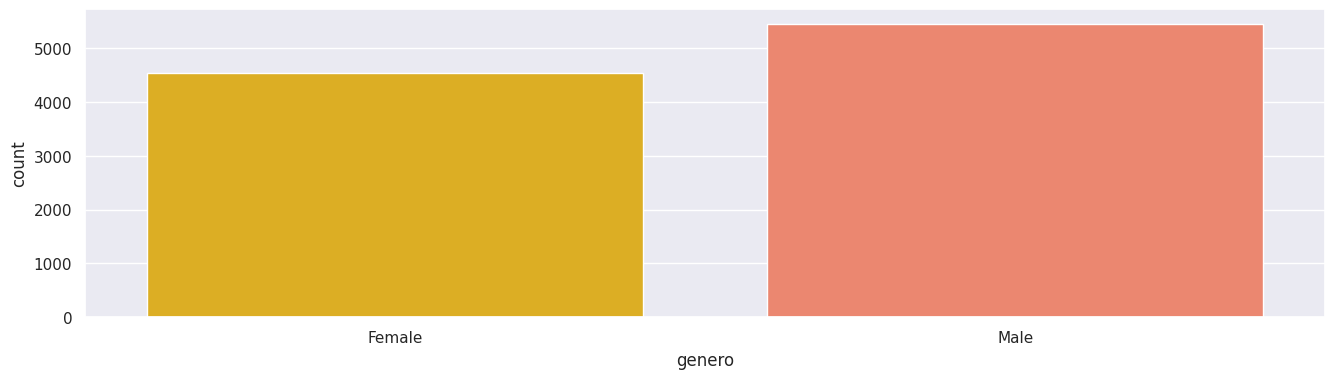

In [43]:
sns.countplot(x= df4['genero'], palette= categorical_palette);

In [44]:
pd.DataFrame({'absoluto': df4['genero'].value_counts(), 'percentual (%)': df4['genero'].value_counts(normalize= True) * 100})

,absoluto,percentual (%)
Male,5457,54.57
Female,4543,45.43


#### *tem_cartao_credito*

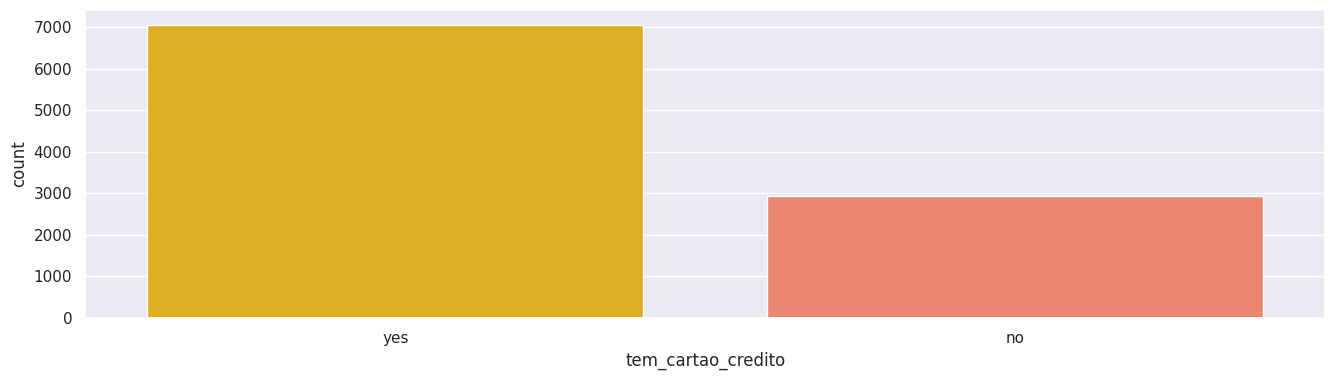

In [45]:
sns.countplot(x= df4['tem_cartao_credito'], palette= categorical_palette);

In [46]:
pd.DataFrame({'absoluto': df4['tem_cartao_credito'].value_counts(), 'percentual (%)': df4['tem_cartao_credito'].value_counts(normalize= True) * 100})

,absoluto,percentual (%)
yes,7055,70.55
no,2945,29.45


#### *membro_ativo*

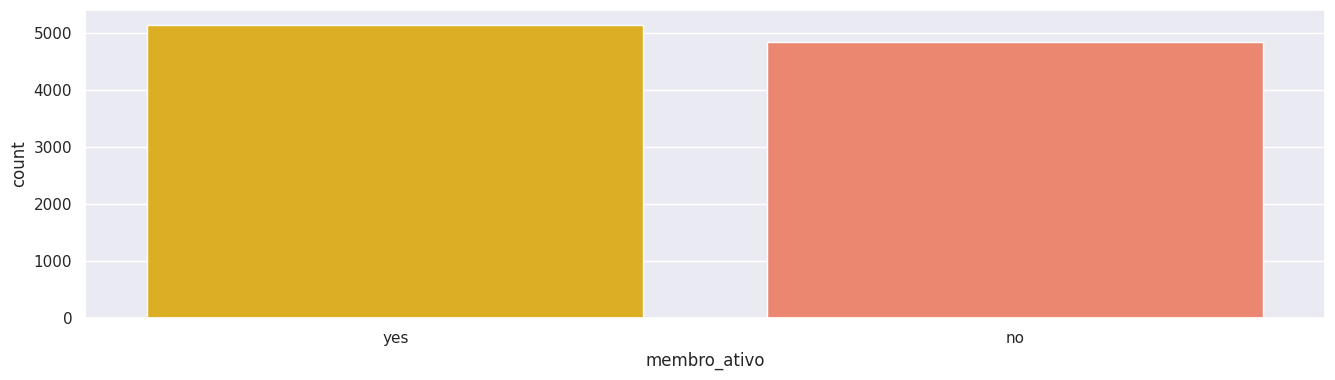

In [47]:
sns.countplot(x= df4['membro_ativo'], palette= categorical_palette);

In [48]:
pd.DataFrame({'absoluto': df4['membro_ativo'].value_counts(), 'percentual (%)': df4['membro_ativo'].value_counts(normalize= True) * 100})

,absoluto,percentual (%)
yes,5151,51.51
no,4849,48.49


#### *escala_fico*

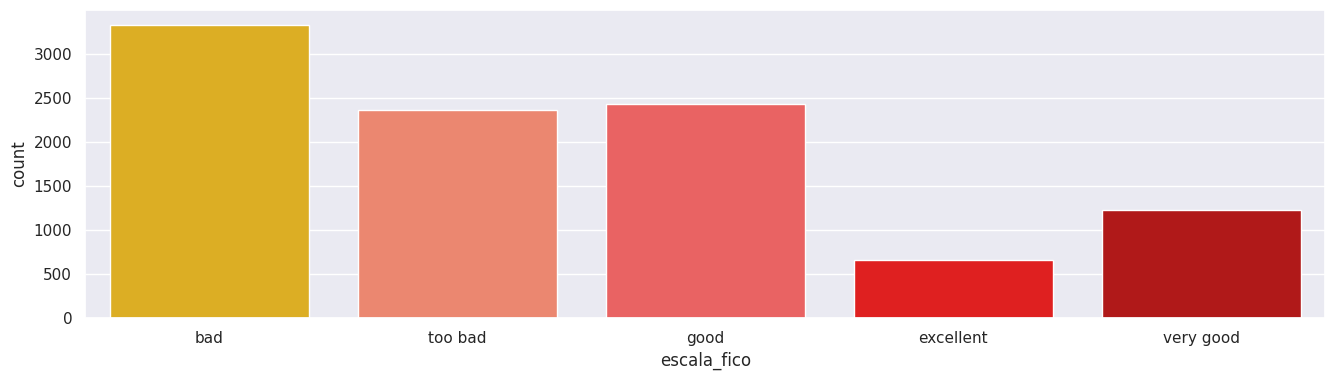

In [49]:
sns.countplot(x= df4['escala_fico'], palette= categorical_palette);

In [50]:
pd.DataFrame({'absoluto': df4['escala_fico'].value_counts(), 'percentual (%)': df4['escala_fico'].value_counts(normalize= True) * 100})

,absoluto,percentual (%)
bad,3331,33.31
good,2428,24.28
too bad,2362,23.62
very good,1224,12.24
excellent,655,6.55


## Bivariate and Multivariate Analysis

### Response Variable x Numeric Variables (lots and few distinct values)

#### *score_credito, idade, saldo, salario_estimado, LTV_medio*

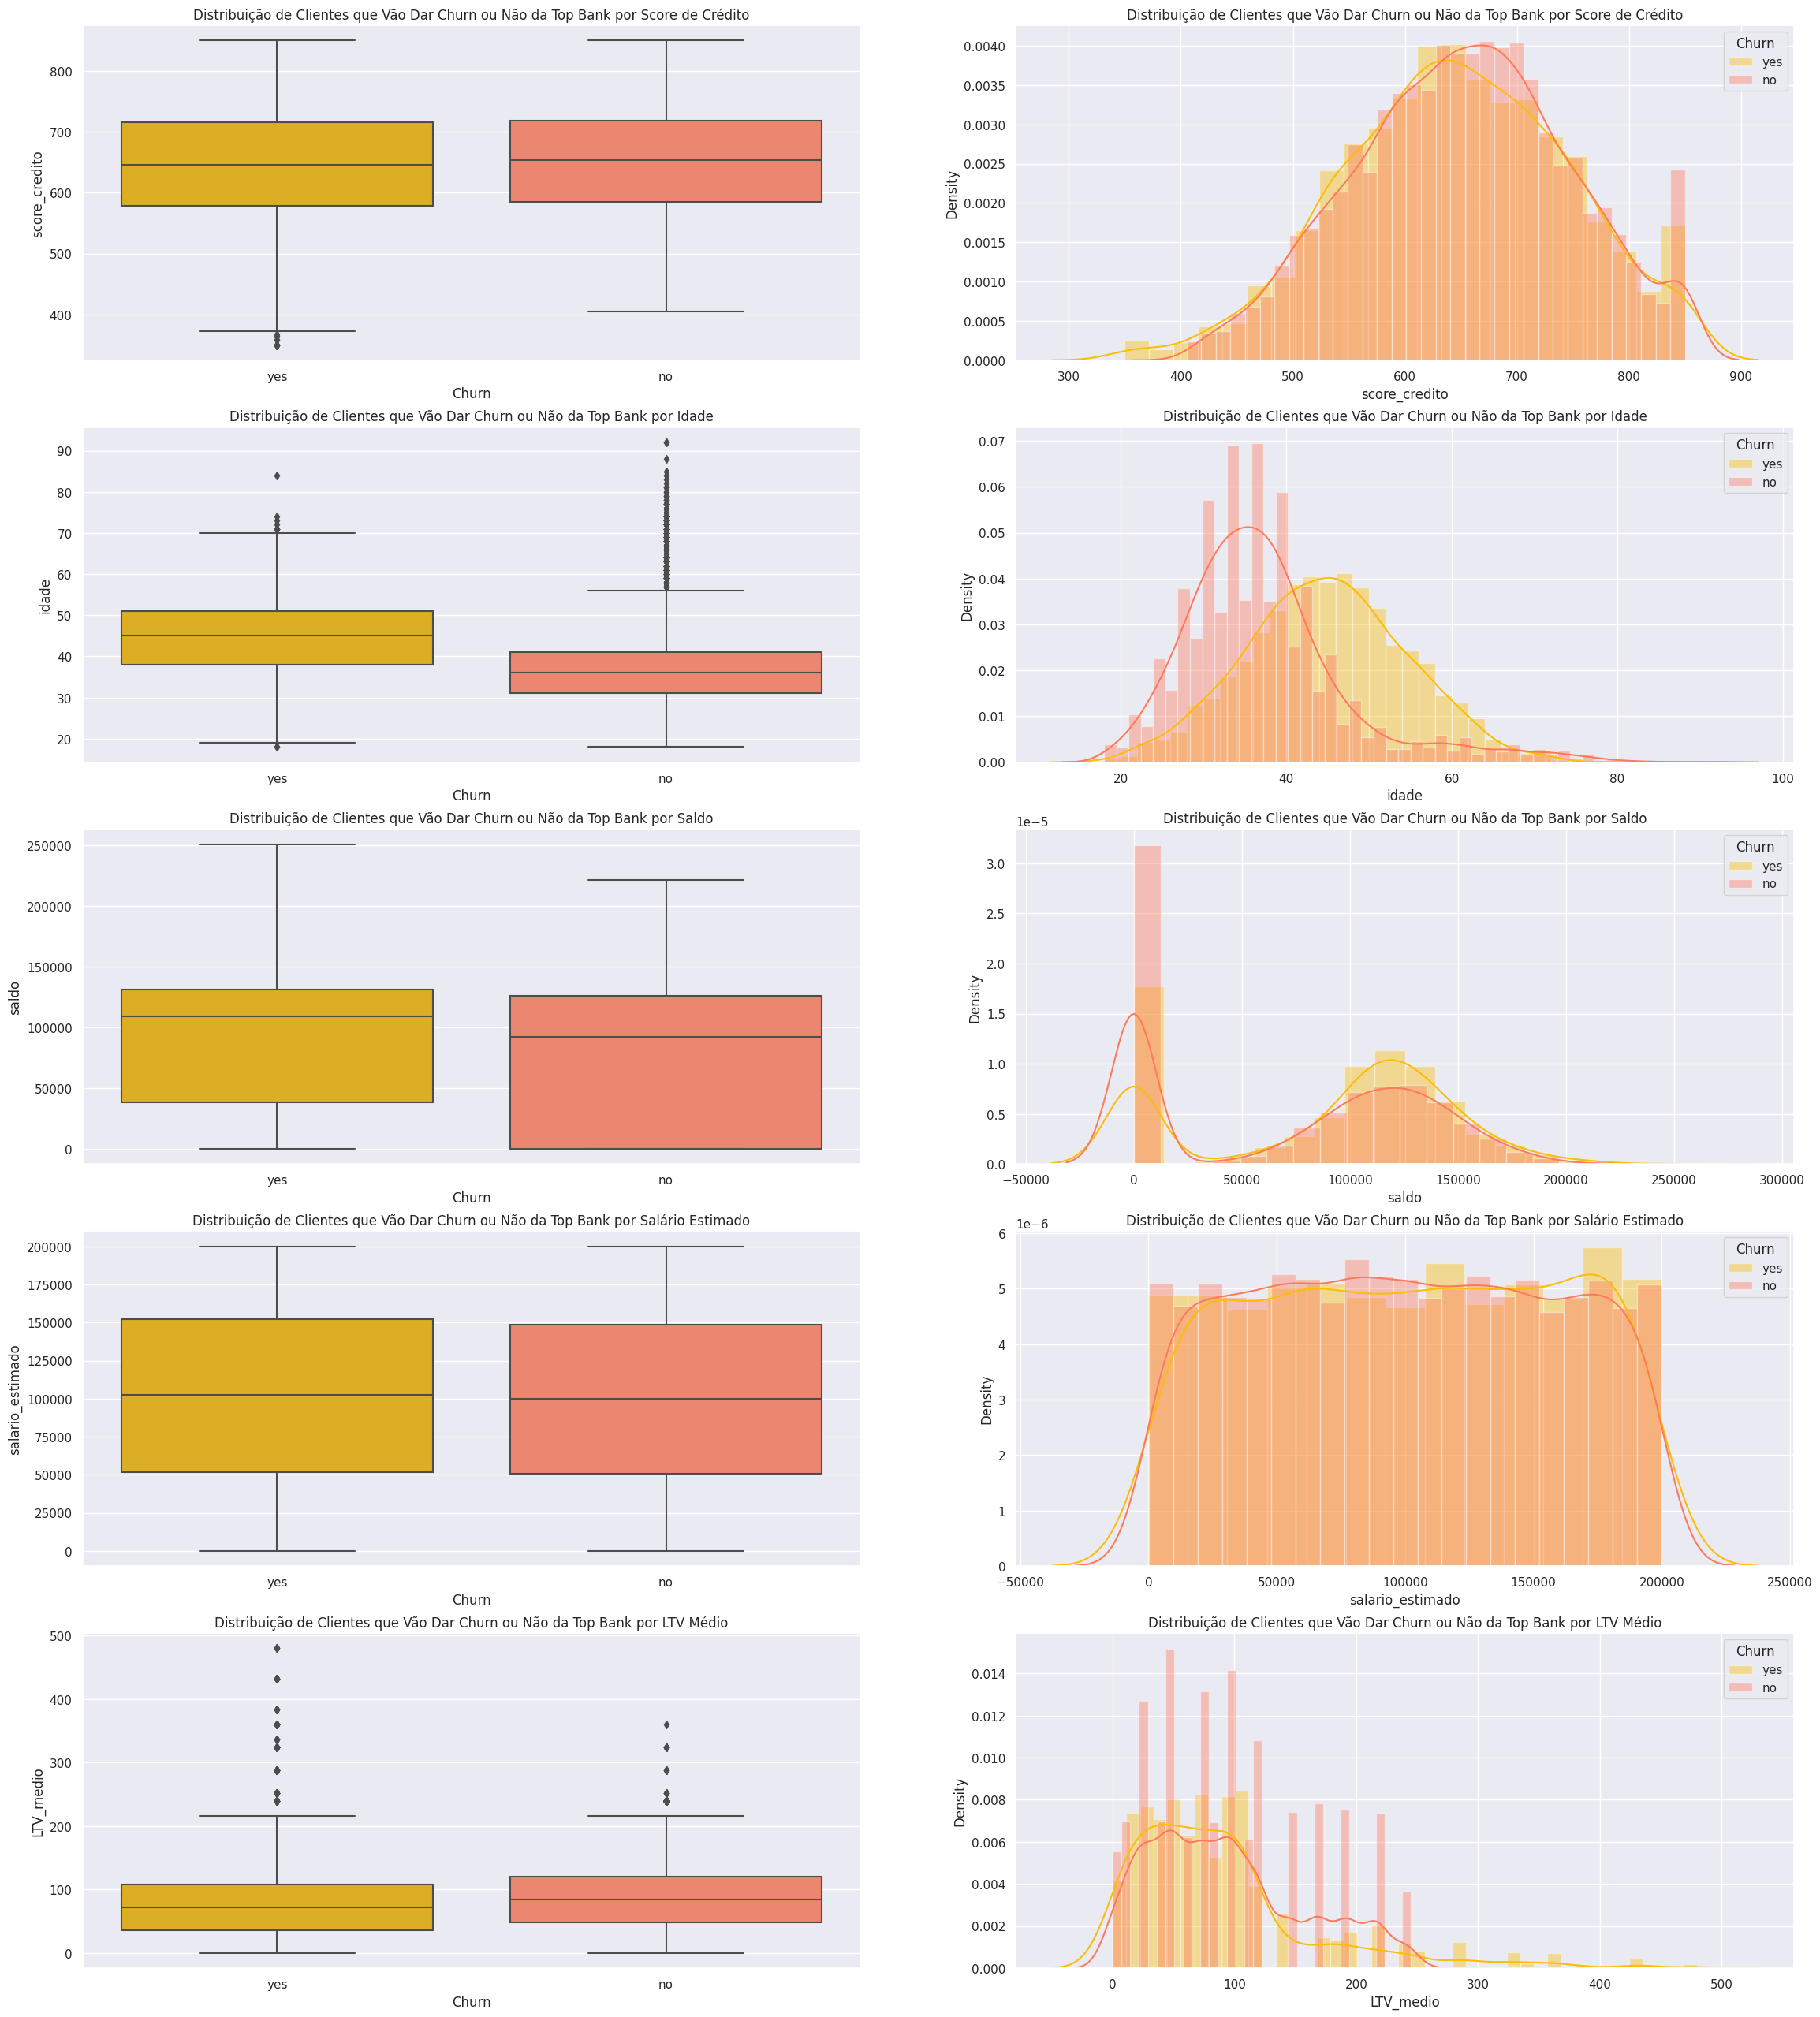

In [51]:
plt.figure(figsize= (28, 32))

#Churn x score_credito
plt.subplot(5, 2, 1)
sns.boxplot(x= 'Churn', y= 'score_credito', data= df4);
plt.title('Distribuição de Clientes que Vão Dar Churn ou Não da Top Bank por Score de Crédito')

plt.subplot(5, 2, 2)
sns.distplot(df4[df4['Churn'] == 'yes']['score_credito'], label= 'yes');
sns.distplot(df4[df4['Churn'] == 'no']['score_credito'], label= 'no');
plt.legend(title= 'Churn');
plt.title('Distribuição de Clientes que Vão Dar Churn ou Não da Top Bank por Score de Crédito')

#Churn x idade
plt.subplot(5, 2, 3)
sns.boxplot(x= 'Churn', y= 'idade', data= df4);
plt.title('Distribuição de Clientes que Vão Dar Churn ou Não da Top Bank por Idade')

plt.subplot(5, 2, 4)
sns.distplot( df4[df4['Churn'] == 'yes']['idade'], label= 'yes');
sns.distplot( df4[df4['Churn'] == 'no']['idade'], label= 'no');
plt.legend(title= 'Churn');
plt.title('Distribuição de Clientes que Vão Dar Churn ou Não da Top Bank por Idade')

#Churn x saldo
plt.subplot(5, 2, 5)
sns.boxplot(x= 'Churn', y= 'saldo', data= df4);
plt.title('Distribuição de Clientes que Vão Dar Churn ou Não da Top Bank por Saldo')

plt.subplot(5, 2, 6)
sns.distplot( df4[df4['Churn'] == 'yes']['saldo'], label= 'yes');
sns.distplot( df4[df4['Churn'] == 'no']['saldo'], label= 'no');
plt.legend(title= 'Churn');
plt.title('Distribuição de Clientes que Vão Dar Churn ou Não da Top Bank por Saldo')

#Churn x salario_estimado
plt.subplot(5, 2, 7)
sns.boxplot(x= 'Churn', y= 'salario_estimado', data= df4);
plt.title('Distribuição de Clientes que Vão Dar Churn ou Não da Top Bank por Salário Estimado')

plt.subplot(5, 2, 8)
sns.distplot( df4[df4['Churn'] == 'yes']['salario_estimado'], label= 'yes');
sns.distplot( df4[df4['Churn'] == 'no']['salario_estimado'], label= 'no');
plt.legend(title= 'Churn');
plt.title('Distribuição de Clientes que Vão Dar Churn ou Não da Top Bank por Salário Estimado')

#Churn x LTV_medio
plt.subplot(5, 2, 9)
sns.boxplot(x= 'Churn', y= 'LTV_medio', data= df4);
plt.title('Distribuição de Clientes que Vão Dar Churn ou Não da Top Bank por LTV Médio')

plt.subplot(5, 2, 10)
sns.distplot( df4[df4['Churn'] == 'yes']['LTV_medio'], label= 'yes');
sns.distplot( df4[df4['Churn'] == 'no']['LTV_medio'], label= 'no');
plt.legend(title= 'Churn');
plt.title('Distribuição de Clientes que Vão Dar Churn ou Não da Top Bank por LTV Médio');

#### *tempo_permanencia*

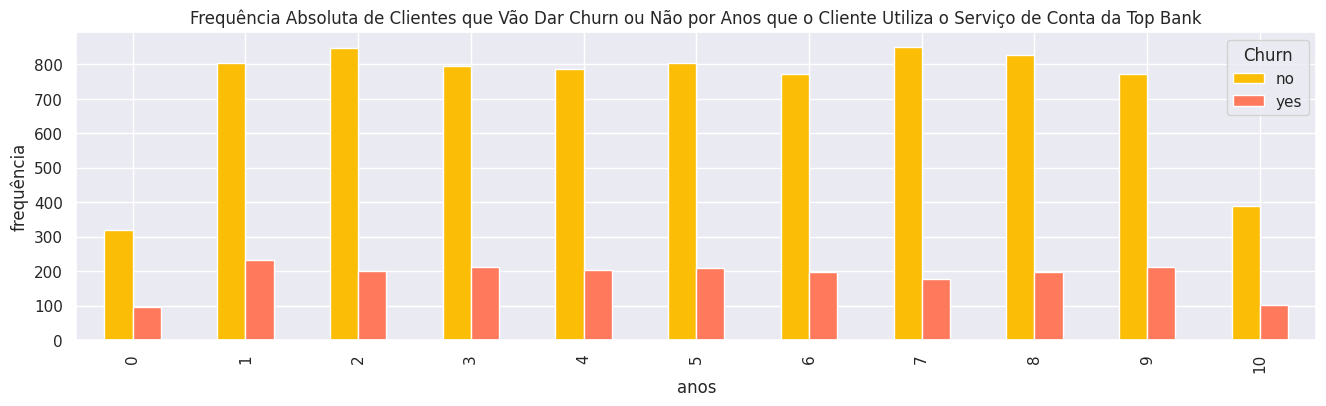

In [52]:
df_aux = df4[['id_cliente','Churn', 'tempo_permanencia']].groupby(['Churn','tempo_permanencia']).count()
df_aux.reset_index().pivot(index='tempo_permanencia', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Anos que o Cliente Utiliza o Serviço de Conta da Top Bank')
plt.xlabel('anos')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

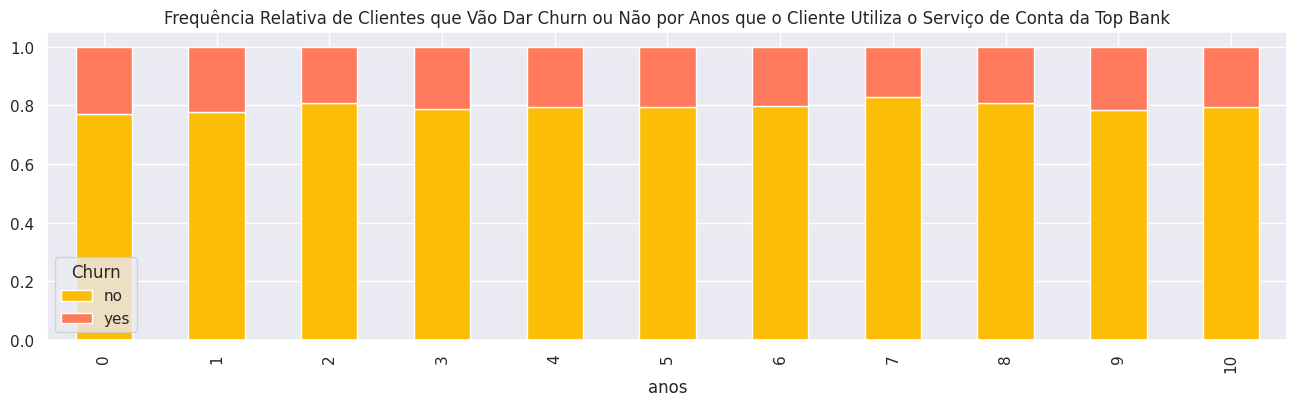

In [53]:
table = pd.crosstab(df4['tempo_permanencia'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativa de Clientes que Vão Dar Churn ou Não por Anos que o Cliente Utiliza o Serviço de Conta da Top Bank')
plt.xlabel('anos')

# Exibe o gráfico
plt.show()

#### numero_de_contas

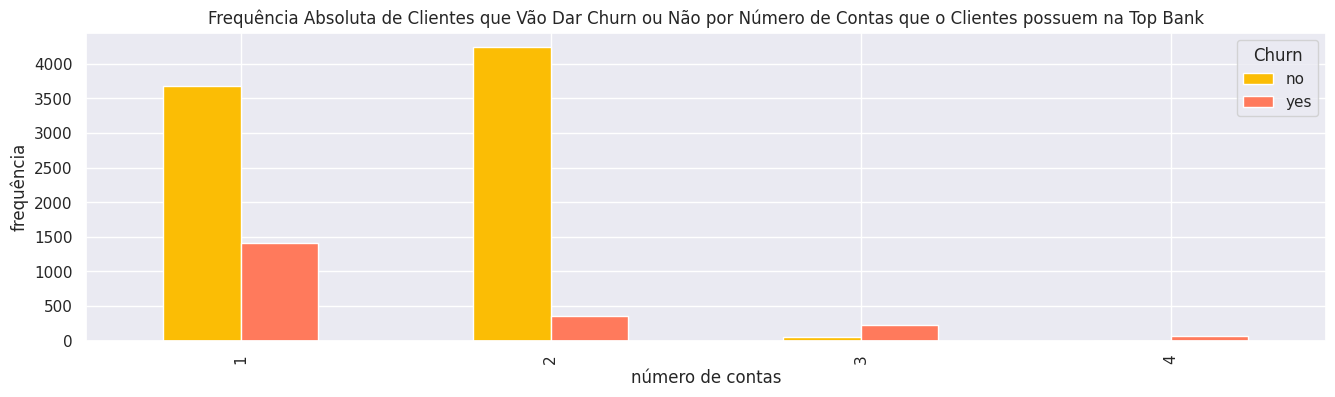

In [54]:
df_aux = df4[['id_cliente','Churn', 'numero_de_contas']].groupby(['Churn','numero_de_contas']).count()
df_aux.reset_index().pivot(index='numero_de_contas', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Número de Contas que o Clientes possuem na Top Bank')
plt.xlabel('número de contas')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

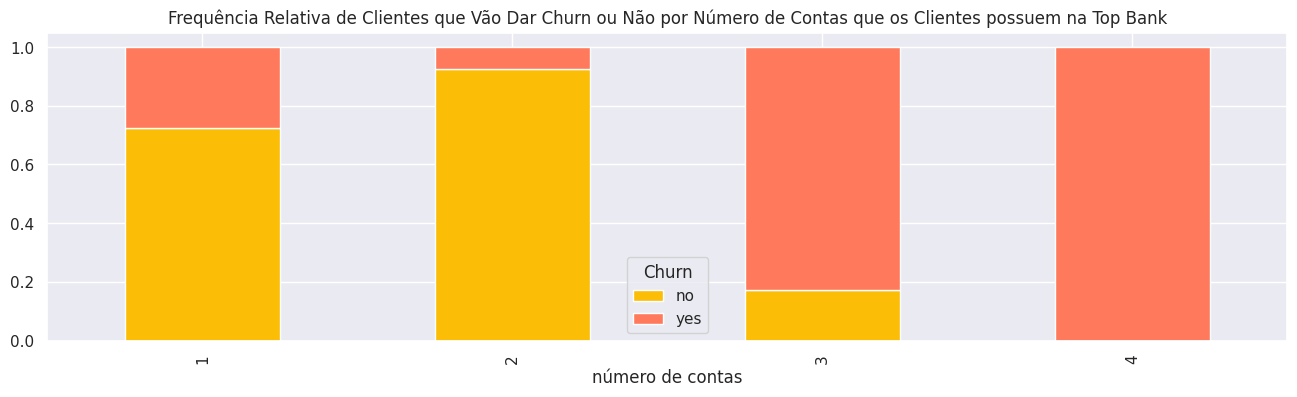

In [55]:
table = pd.crosstab(df4['numero_de_contas'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativa de Clientes que Vão Dar Churn ou Não por Número de Contas que os Clientes possuem na Top Bank')
plt.xlabel('número de contas')

# Exibe o gráfico
plt.show()

### Response Variable x Categorical Variables

#### *geografia*

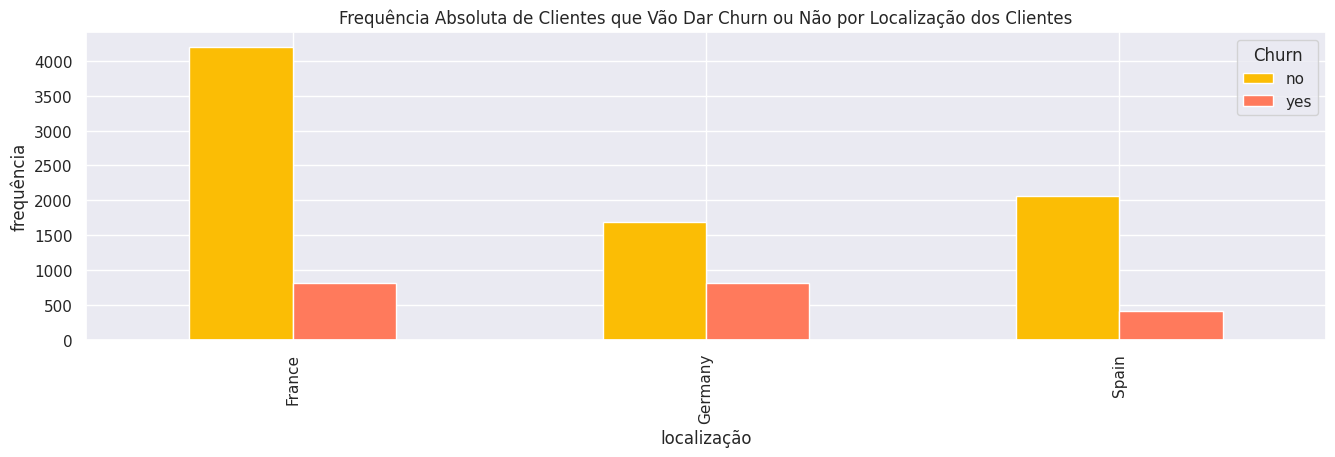

In [56]:
df_aux = df4[['id_cliente','Churn', 'geografia']].groupby(['Churn','geografia']).count()
df_aux.reset_index().pivot(index='geografia', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Localização dos Clientes')
plt.xlabel('localização')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

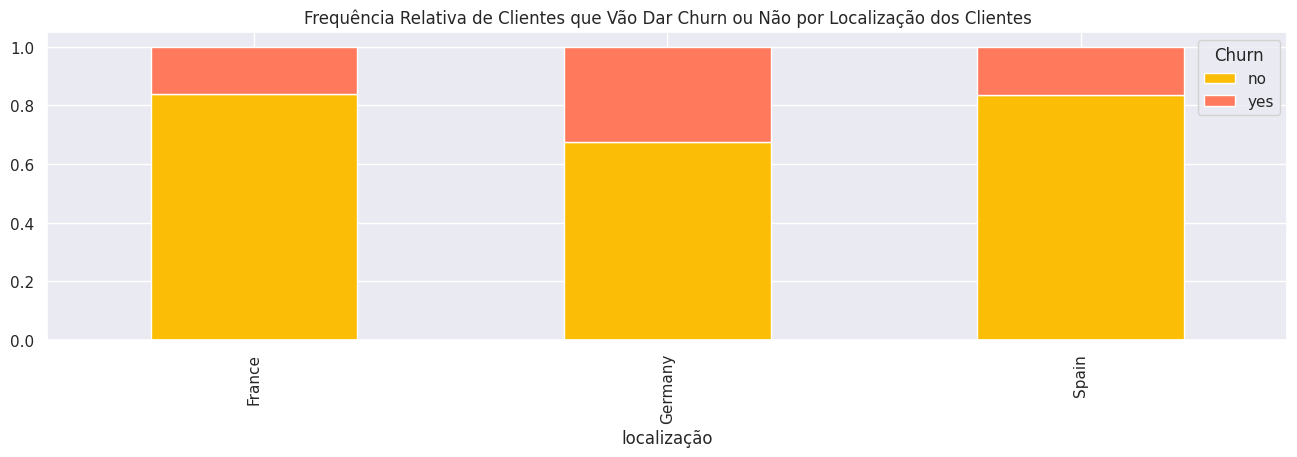

In [57]:
table = pd.crosstab(df4['geografia'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativa de Clientes que Vão Dar Churn ou Não por Localização dos Clientes')
plt.xlabel('localização')

# Exibe o gráfico
plt.show()

#### *genero*

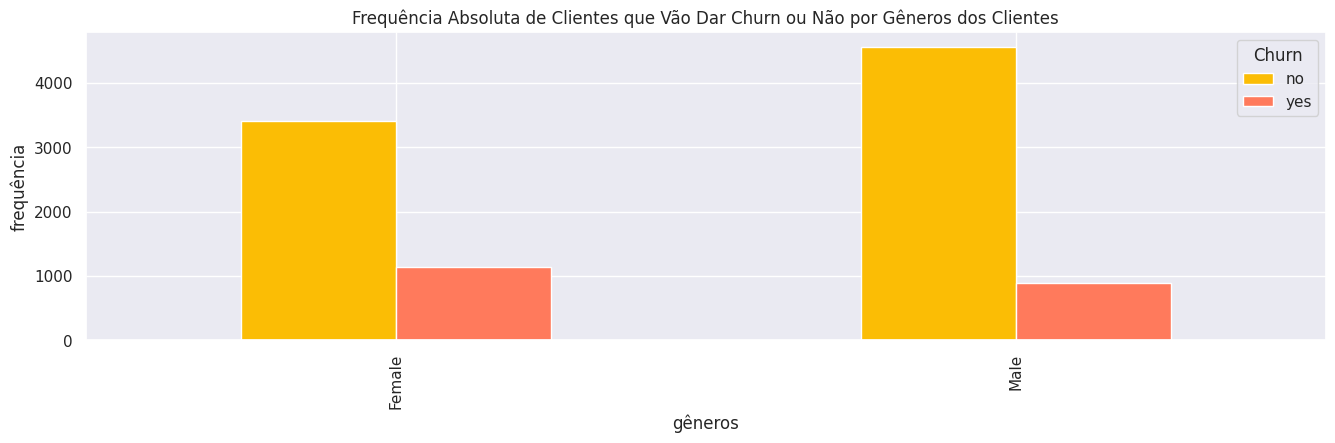

In [58]:
df_aux = df4[['id_cliente','Churn', 'genero']].groupby(['Churn','genero']).count()
df_aux.reset_index().pivot(index='genero', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Gêneros dos Clientes')
plt.xlabel('gêneros')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

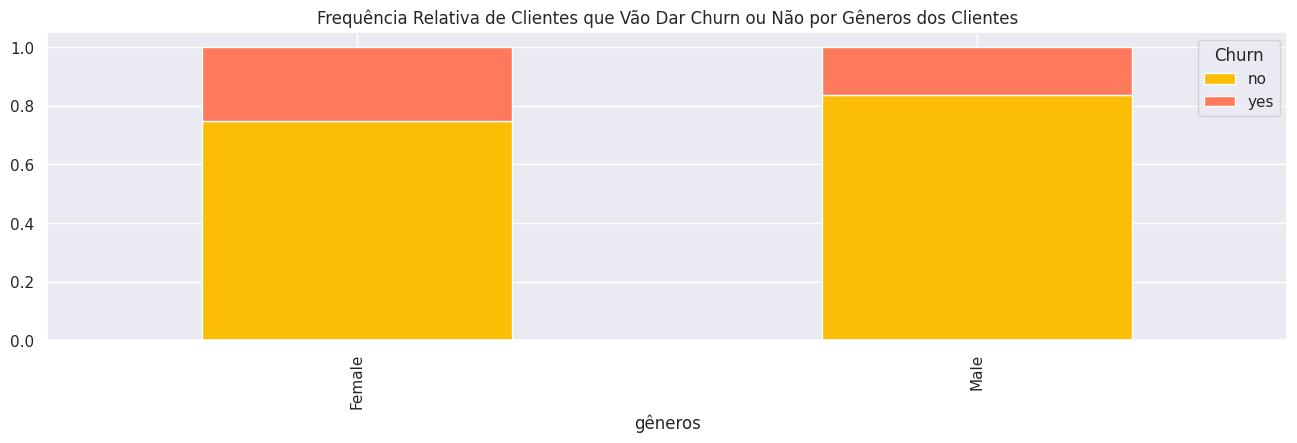

In [59]:
table = pd.crosstab(df4['genero'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativa de Clientes que Vão Dar Churn ou Não por Gêneros dos Clientes')
plt.xlabel('gêneros')

# Exibe o gráfico
plt.show()

#### *tem_cartao_credito*

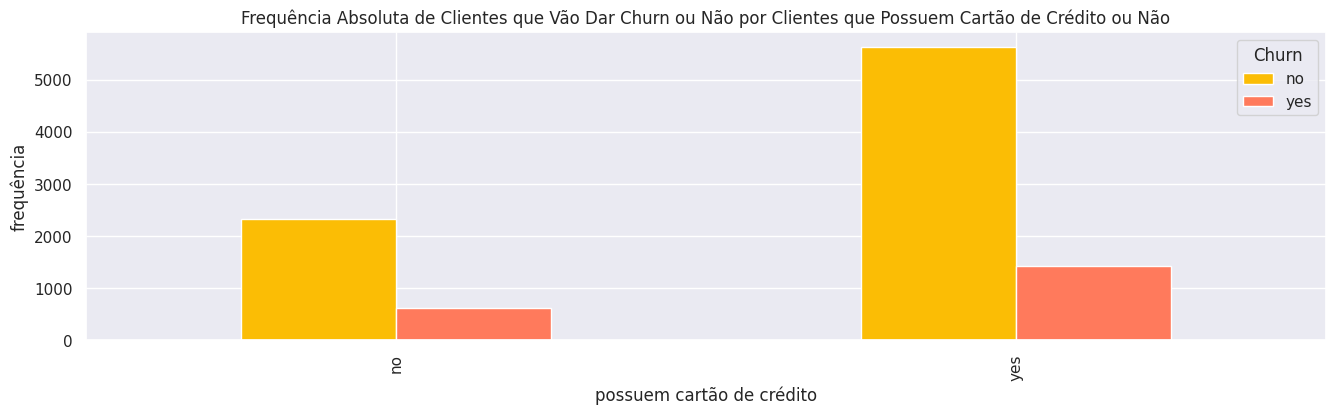

In [60]:
df_aux = df4[['id_cliente','Churn', 'tem_cartao_credito']].groupby(['Churn','tem_cartao_credito']).count()
df_aux.reset_index().pivot(index='tem_cartao_credito', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Clientes que Possuem Cartão de Crédito ou Não')
plt.xlabel('possuem cartão de crédito')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

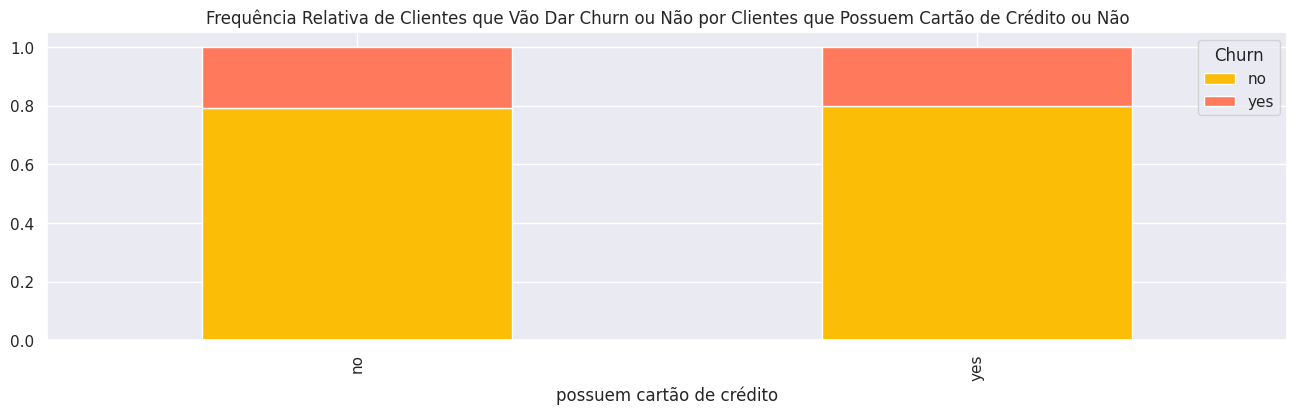

In [61]:
table = pd.crosstab(df4['tem_cartao_credito'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativa de Clientes que Vão Dar Churn ou Não por Clientes que Possuem Cartão de Crédito ou Não')
plt.xlabel('possuem cartão de crédito')

# Exibe o gráfico
plt.show()

#### *membro_ativo*

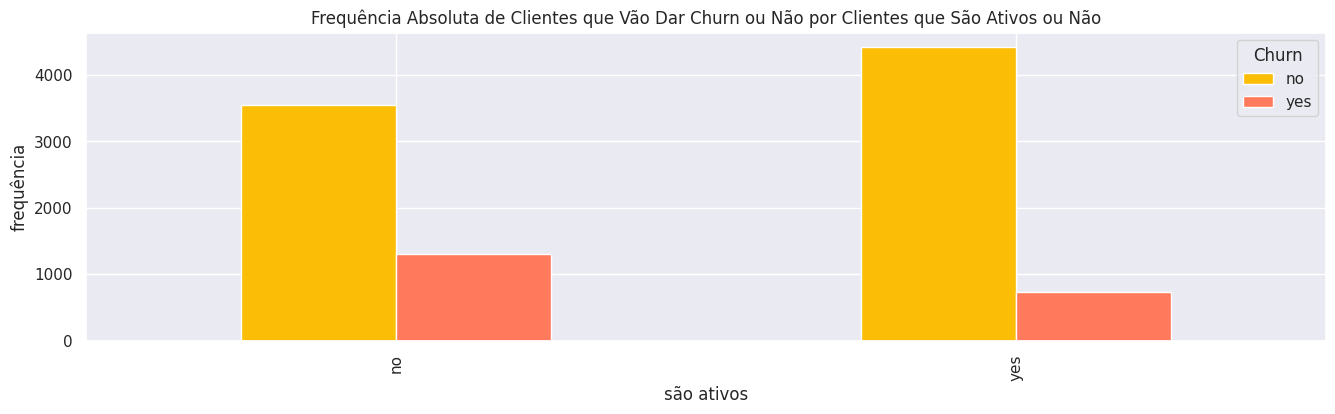

In [62]:
df_aux = df4[['id_cliente','Churn', 'membro_ativo']].groupby(['Churn','membro_ativo']).count()
df_aux.reset_index().pivot(index='membro_ativo', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Clientes que São Ativos ou Não')
plt.xlabel('são ativos')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

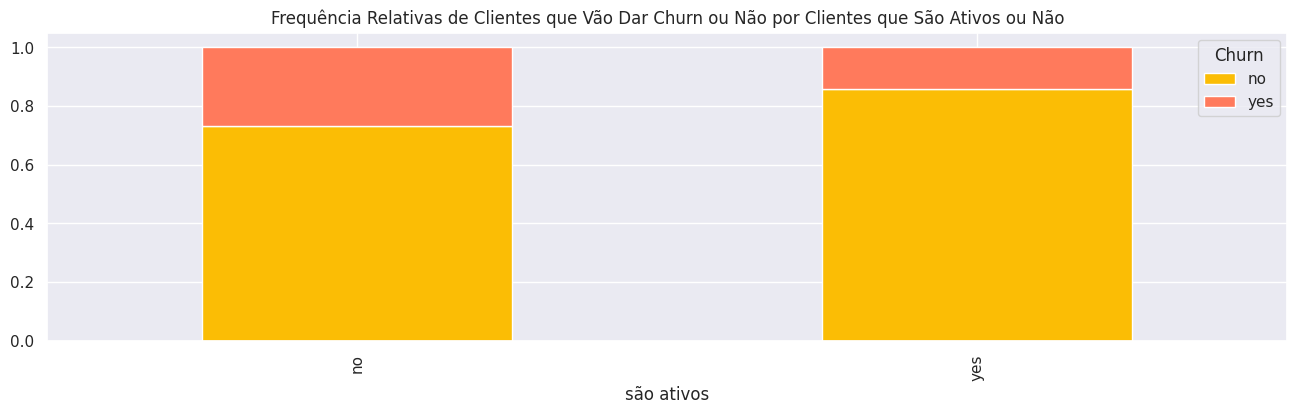

In [63]:
table = pd.crosstab(df4['membro_ativo'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativas de Clientes que Vão Dar Churn ou Não por Clientes que São Ativos ou Não')
plt.xlabel('são ativos')

# Exibe o gráfico
plt.show()

#### *escala_fico*

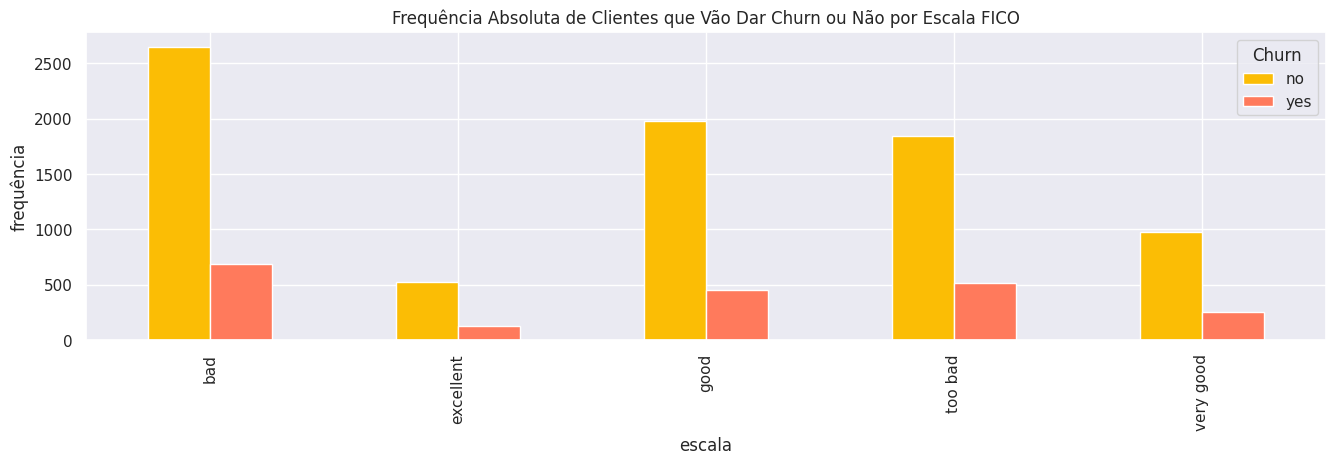

In [64]:
df_aux = df4[['id_cliente','Churn', 'escala_fico']].groupby(['Churn','escala_fico']).count()
df_aux.reset_index().pivot(index='escala_fico', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Escala FICO')
plt.xlabel('escala')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

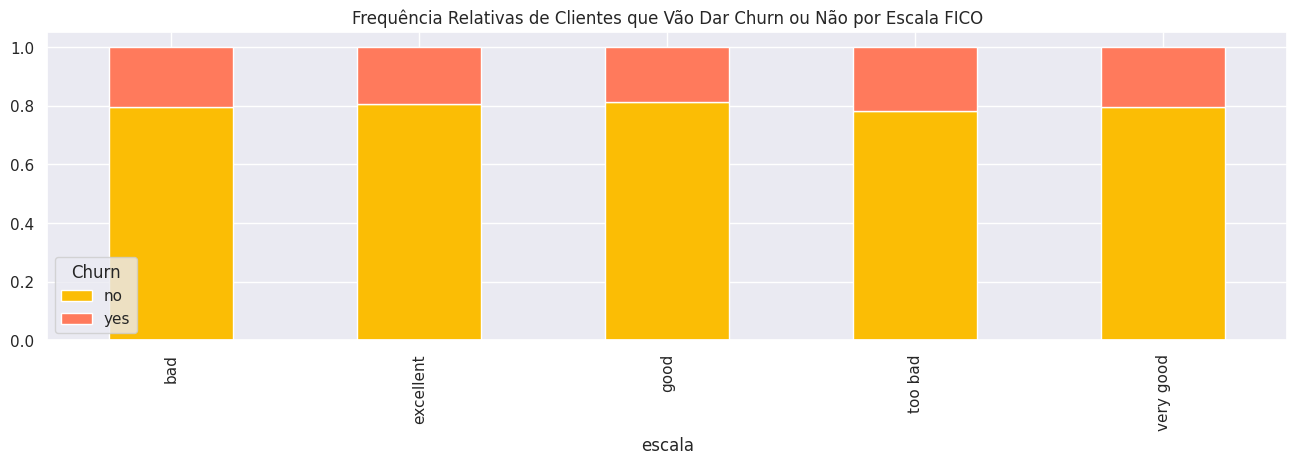

In [65]:
table = pd.crosstab(df4['escala_fico'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativas de Clientes que Vão Dar Churn ou Não por Escala FICO')
plt.xlabel('escala')

# Exibe o gráfico
plt.show()

## Multivariate Analysis

### Categorical Variables

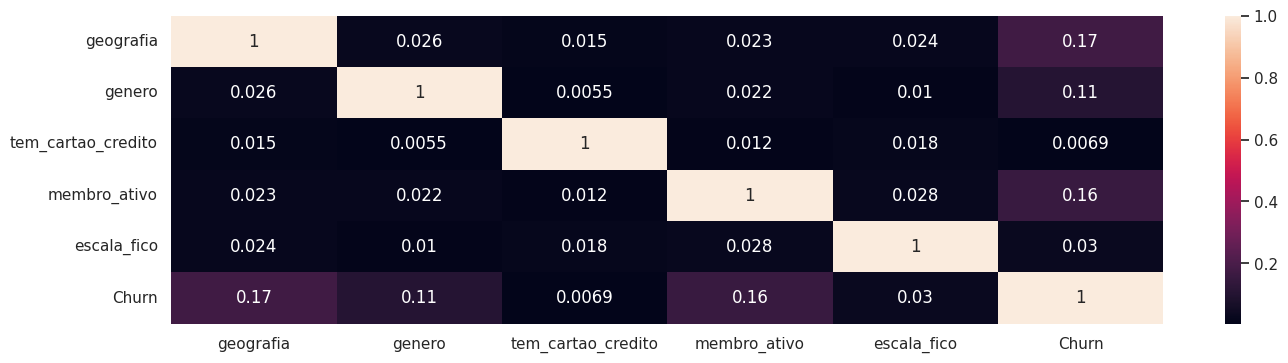

In [66]:
categorical_dataframe = categorical_attributes

#calculate Cramer's V
cramer_v1 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['geografia'])
cramer_v2 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['genero'])
cramer_v3 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['tem_cartao_credito'])
cramer_v4 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['membro_ativo'])
cramer_v5 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['escala_fico'])
cramer_v6 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['Churn'])

cramer_v7 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['geografia'])
cramer_v8 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['genero'])
cramer_v9 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['tem_cartao_credito'])
cramer_v10 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['membro_ativo'])
cramer_v11 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['escala_fico'])
cramer_v12 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['Churn'])

cramer_v13 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['geografia'])
cramer_v14 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['genero'])
cramer_v15 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['tem_cartao_credito'])
cramer_v16 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['membro_ativo'])
cramer_v17 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['escala_fico'])
cramer_v18 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['Churn'])

cramer_v19 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['geografia'])
cramer_v20 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['genero'])
cramer_v21 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['tem_cartao_credito'])
cramer_v22 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['membro_ativo'])
cramer_v23 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['escala_fico'])
cramer_v24 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['Churn'])

cramer_v25 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['geografia'])
cramer_v26 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['genero'])
cramer_v27 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['tem_cartao_credito'])
cramer_v28 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['membro_ativo'])
cramer_v29 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['escala_fico'])
cramer_v30 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['Churn'])

cramer_v31 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['geografia'])
cramer_v32 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['genero'])
cramer_v33 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['tem_cartao_credito'])
cramer_v34 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['membro_ativo'])
cramer_v35 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['escala_fico'])
cramer_v36 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['Churn'])

#final dataset
cramer_v_dataset = pd.DataFrame({'geografia': [cramer_v1, cramer_v2, cramer_v3, cramer_v4, cramer_v5, cramer_v6],
                                 'genero': [cramer_v7, cramer_v8, cramer_v9, cramer_v10, cramer_v11, cramer_v12], 
                                 'tem_cartao_credito': [cramer_v13, cramer_v14, cramer_v15, cramer_v16, cramer_v17, cramer_v18],
                                 'membro_ativo': [cramer_v19, cramer_v20, cramer_v21, cramer_v22, cramer_v23, cramer_v24],
                                 'escala_fico': [cramer_v25, cramer_v26, cramer_v27, cramer_v28, cramer_v29, cramer_v30],
                                 'Churn': [cramer_v31, cramer_v32, cramer_v33, cramer_v34, cramer_v35, cramer_v36]})

cramer_v_dataset = cramer_v_dataset.set_index(cramer_v_dataset.columns)

sns.heatmap(cramer_v_dataset, annot= True);

### Numeric Variables

In [67]:
df4['Churn'] = df4['Churn'].apply(lambda x: 1 if x == 'yes' else 0)

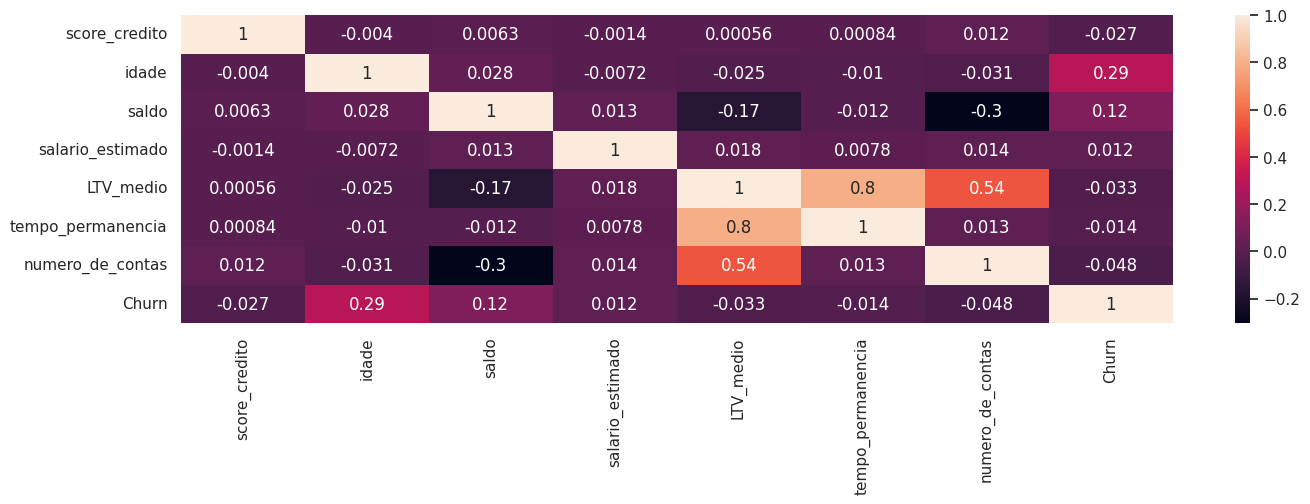

In [68]:
variables =  df4[['score_credito', 'idade', 'saldo', 'salario_estimado', 'LTV_medio', 'tempo_permanencia', 'numero_de_contas', 'Churn']]
correlation = variables.corr(method= 'pearson')
sns.heatmap(correlation, annot= True);

## Note:
Informações Importantes:

**Análise Univariada:**
- ***score_credito***: existem poucos outliers que não são tão relevantes devido ao valor da curtose, logo podem permanecer.
- ***idade***: existem muitos outliers relevantes na variável, acima de 62 anos. Vale tratá-los.
- ***salario_estimado***: mais de 36% dos clientes possuem contas zeradas, evidenciado pela variável .
- ***LTV_medio***: existem muitos outliers relevantes na variável , acima de 4560 dolares. Vale tratá-los.
- ***numero_de_contas***: apenas 3,26% de cleintes possuem 3 ou 4 contas.
- ***geografia***: metade dos clientes são da França (50,14%). A outra metade se divide praticamente igual entre Alemanha (25.09%) e Espanha (24.77%)
- ***tem_cartao_credito***: 70.55% dos clientes possuem cartão de crédito.
- ***escala_fico***: menos de 20% possuem scores muito bons ou excelentes.

**Análise Bivariada e Multivariada**
- ***score_credito***: não há efeito significativo na variável Churn. Apenas poucos outliers com scores próximos de 350 na distribuição de clientes positivos para Churn.
- ***idade***: <span style="background:LightGreen">há efeito significativo na variável Churn. Clientes negativos para churn tendem a ser mais novos (metade dos dados entre 32 - 42 anos e presença de muitos outliers a partir de 56 anos) e clientes positivos tendem a ser mais velhos (metdade dos dados entre 36 - 52 anos e presença de poucos outliers a partir de 70 anos e abaixo de 19).</span>
- ***saldo***: <span style="background:LightYellow">pode ter efeito significativo na variável Churn, sem muito impacto. A diferença que chama atenção entre as distribuições, é a presença de 0, onde clientes positivos para churn e que possuem o saldo zerado são quase o dobro em relação aos clientes negativos para churn e que possuem o saldo zerado.</span>
- ***salario_estimado***: <span style="background:LightYellow">pode ter efeito significativo na variável Churn, sem muito impacto. Apenas chama atenção um detalhe, onde salários maiores, próximos de US200000.00 tem uma proporção de Churn maior. ou seja, salários mais altos, mais de rotatividade.</span>
- ***LTV_medio***: não há efeito significativo na variável Churn. Existe apenas uma pequena diferença entre as distribuições LTV de clientes positivos e negativos para Churn, onde clientes positivos para Churn tendem a ter um LTV um pouco menor em relação aos clientes negativos, e presença de outliers a partir de 4200. Junto com o histograma, fica evidente também que a maioria dos cliente que possuem LTV médio querem permanecer e os que possuem LTV alto querem sair.
- ***tempo_permanencia***: não há efeito significativo na variável Churn. Todas os anos possuem quase o mesmo padrão, onde 20% querem sair do banco e 80% não.
- ***numero_de_contas***:não há efeito significativo na variável Churn. 100% dos que possuem 4 contas e 80% dos que possuem 3 contas querem sair do banco, porém esses clientes que possuem 3 ou 4 representam um porcentagem muito pequena do conjunto de dados (menos de 5%).</span>

- ***geografia***: <span style="background:LightYellow">pode ter um efeito significativo na variável Churn, sem muito impacto. De todos os clientes que residem na França ou na Espanha, apenas 16% querem sair do banco. Mas a Alemanha tem essa proporção dobrada, 32% querem sair do banco.</span>

- ***genero***: <span style="background:LightYellow">pode ter um efeito significativo na variável Churn, sem muito impacto. Mulheres querem sair do banco mais que os homens. 25% das mulheres e 16% dos homens.</span>

- ***tem_cartao_credito***: não há efeito significativo na variável Churn. De todos os cliente que possuem cartão ou não, apenas 20% querem sair do banco.

- ***membro_ativo***: <span style="background:LightYellow">pode ter um efeito significativo na variável Churn. Essa variável possui quase o mesmo comportamento da variável gênero, onde Clientes inativos querem sair do banco mais que os inativos. 26%  dos inativos e 14% dos ativos.</span>

- ***escala_fico***: não há efeito significativo na variável Churn. Todas as classes possuem quase o mesmo padrão, onde 20% querem sair do banco e 80% não.


Próxima versão: 
- Criar função para plotagens dos gráficos na análise bivariada.

# Feature Engineering II (Data Preparation)

In [69]:
df5 = df4.copy()

## Data Filtering

In [70]:
data_for_filtering = df5.copy()

In [71]:
columns_to_delete = ['numero_linha', 'id_cliente', 'sobrenome']
filtered_data = data_for_filtering.drop(columns_to_delete, axis= 1) 

In [72]:
filtered_data.head()

,score_credito,geografia,genero,idade,tempo_permanencia,saldo,numero_de_contas,tem_cartao_credito,membro_ativo,salario_estimado,Churn,escala_fico,LTV_medio
0,619,France,Female,42,2,0.00,1,yes,yes,101348.88,1,bad,24
1,608,Spain,Female,41,1,83807.86,1,no,yes,112542.58,0,bad,12
2,502,France,Female,42,8,159660.80,3,yes,no,113931.57,1,too bad,288
3,699,France,Female,39,1,0.00,2,no,no,93826.63,0,good,24
4,850,Spain,Female,43,2,125510.82,1,yes,yes,79084.10,0,excellent,24


## Splitting Dataframe into Training and Test Dataset

In [73]:
X = filtered_data.drop(columns = ['Churn'])
y = filtered_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state= 42)

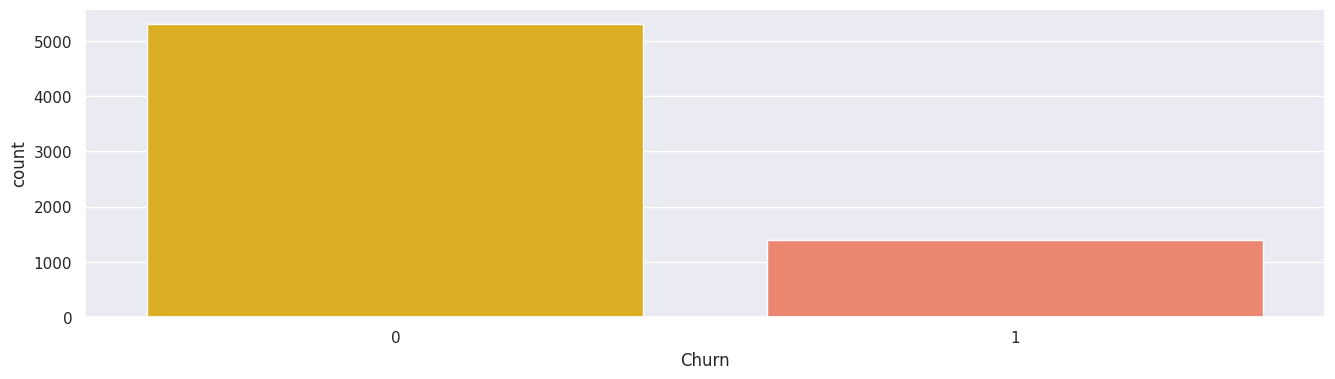

In [74]:
sns.countplot(x= y_train);

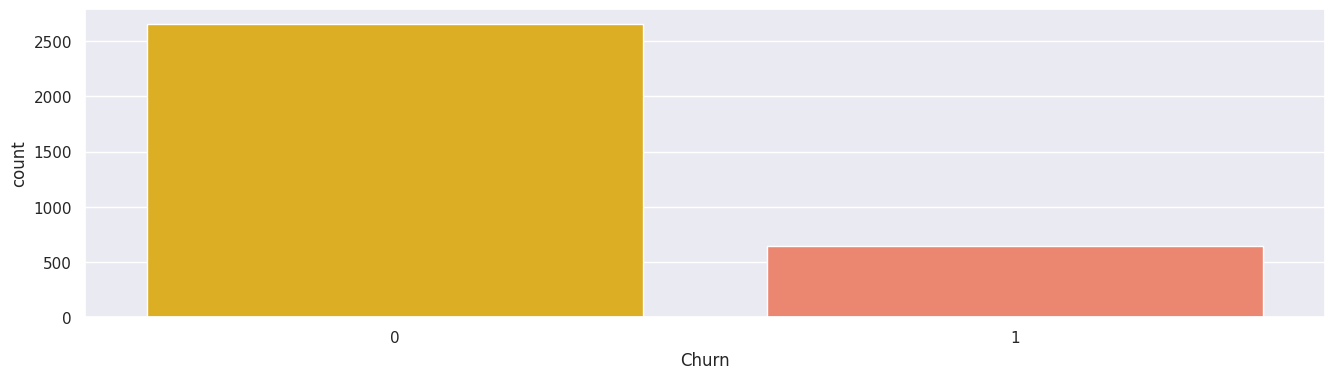

In [75]:
sns.countplot(x= y_test);

## Creation of the New Features II

- A estratégia na criação de novas variáveis é usar variáveis reconhecidas pelo brainstorm de negócio e com efeitos significativos na variável Churn evidenciada pela análise exploratória de dados e combiná-las para potencializar seus impactos. 

**Brainstorm**

Principais fatores para um cliente querer fechar uma conta/sair de um banco:

1. Corte de gastos

		P: O que leva uma pessoa a cortar gastos?
		R: Ou o salário foi reduzido, ou faltou organização financeira, entrando em endividamento.
		Variáveis disponíveis impactadas: salario_estimado baixo, score_credito baixo, saldo baixo, tem_cartao_credito
	
2. Insatisfação com o Banco

		P: O que leva uma pessoa a estar insatisfeita com um banco?
    	R: Suporte ruim, taxas elevadas, falta de transparência, problemas com transações ou aplicações, falta na segurança dos dados.
		Variáveis disponíveis impactadas: tempo_permanencia curto, negativo para membro_ativo.

3. Concorrente tem mais benefícios
		
        Variáveis disponíveis impactadas: nenhuma.

Principais fatores para um cliente querer fechar uma conta/sair de um banco:

1. Comodidade aliado com benefícios, e bom produto.
		Variáveis disponíveis que impactam a causa: tempo_permanencia, membro_ativo, numero_de_contas, tem_cartao_credito

- Variáveis do Brainstorm: [<span style="background:LightYellow">'salario_estimado', 'saldo', 'membro_ativo'</span>, 'score_credito', 'tem_cartao_credito', 'tempo_permanencia', 'numero_de_contas', 'tem_cartao_credito']
- Variáveis da Análise Exploratória: [<span style="background:LightGreen">'idade'</span>, <span style="background:LightYellow">'saldo', 'salario_estimado', 'geografia', 'genero', 'membro_ativo'</span>] 

Idéias de Variáveis:

	1. taxa de saldo por salário (saldo/salario_estimado) > combinação de impacto fraco + impacto fraco
    2. scores acumulado por cada ano de idade (score_credito/idade) > combinação de nenhum impacto + impacto forte
    3. taxa de tempo no banco por idade (tempo_permanencia/idade) > combinação de nenhum impacto + impacto forte
    4. taxa de numero de contas por idade (numero_de_contas/idade) > combinação de nenhum impacto + impacto forte
    5. saldo acumulado por cada ano de idade (saldo/idade) > combinação de impacto fraco + impacto forte
    6. salário por idade (salario_estimado/idade) > combinação de impacto fraco + impacto forte
    7. média de saldo por idade (media de saldo por agrupamento de idade) > combinação de impacto fraco + impacto forte
    8. média de salário por idade (media de salario_estimado por agrupamento de idade) > combinação de impacto fraco + impacto forte
    9. média de saldo por geografia (media de saldo por geografia) > combinação de impacto fraco + impacto fraco
    10. média de salário por geografia (media de salario_estimado por agrupamento de idade) > combinação de impacto fraco + impacto forte

### *Train Data*

In [76]:
X_train['taxa_saldo_por_salario'] = X_train['saldo'] / X_train['salario_estimado']

In [77]:
X_train['score_credito_por_idade'] = X_train['score_credito'] / X_train['idade']

In [78]:
X_train['taxa_tempo_permanencia_por_idade'] = X_train['tempo_permanencia'] / X_train['idade']

In [79]:
X_train['taxa_numero_contas_por_idade'] = X_train['numero_de_contas'] / X_train['idade']

In [80]:
X_train['saldo_por_idade'] = X_train['saldo'] / X_train['idade']

In [81]:
X_train['salario_por_idade'] = X_train['salario_estimado'] / X_train['idade']

In [82]:
#Média de saldo por idade
mean_balance_for_age = X_train[['saldo', 'idade']].groupby('idade').mean().reset_index()
mean_balance_for_age.columns = ['idade', 'media_saldo_por_idade']

#merge'
X_train = pd.merge(X_train, mean_balance_for_age, on= 'idade', how= 'left')

In [83]:
#Média salarial por idade
mean_salary_for_age = X_train[['salario_estimado', 'idade']].groupby('idade').mean().reset_index()
mean_salary_for_age.columns = ['idade', 'media_salarial_por_idade']

#merge'
X_train = pd.merge(X_train, mean_salary_for_age, on= 'idade', how= 'left')

In [84]:
#Média de saldo por geografia
mean_balance_for_geography = X_train[['saldo', 'geografia']].groupby('geografia').mean().reset_index()
mean_balance_for_geography.columns = ['geografia', 'media_saldo_por_geografia']

#merge'
X_train = pd.merge(X_train, mean_balance_for_geography, on= 'geografia', how= 'left')

In [85]:
#Média de salarial por geografia
mean_salary_for_geography = X_train[['salario_estimado', 'geografia']].groupby('geografia').mean().reset_index()
mean_salary_for_geography.columns = ['geografia', 'media_salarial_por_geografia']

#merge'
X_train = pd.merge(X_train, mean_salary_for_geography, on= 'geografia', how= 'left')

In [86]:
X_train.sample(5)

,score_credito,geografia,genero,idade,tempo_permanencia,saldo,numero_de_contas,tem_cartao_credito,membro_ativo,salario_estimado,escala_fico,LTV_medio,taxa_saldo_por_salario,score_credito_por_idade,taxa_tempo_permanencia_por_idade,taxa_numero_contas_por_idade,saldo_por_idade,salario_por_idade,media_saldo_por_idade,media_salarial_por_idade,media_saldo_por_geografia,media_salarial_por_geografia
4201,807,Spain,Female,28,7,165969.26,3,yes,no,156122.13,excellent,252,1.063073,28.821429,0.250000,0.107143,5927.473571,5575.790357,71050.104350,95173.794068,60122.033096,100705.888493
112,692,France,Male,27,1,125547.53,1,no,no,7900.46,good,12,15.891167,25.629630,0.037037,0.037037,4649.908519,292.609630,68498.171959,101702.351824,62758.388947,100867.362001
2656,550,France,Male,37,3,0.00,1,yes,yes,179670.31,too bad,36,0.000000,14.864865,0.081081,0.027027,0.000000,4855.954324,84823.928418,101835.994448,62758.388947,100867.362001
6596,548,Germany,Male,32,2,98986.28,1,yes,yes,55867.38,too bad,24,1.771808,17.125000,0.062500,0.031250,3093.321250,1745.855625,71108.459517,98224.076617,119646.478546,101799.363683
1750,657,Spain,Male,67,5,119785.47,2,yes,yes,107534.32,bad,120,1.113928,9.805970,0.074627,0.029851,1787.842836,1604.989851,78398.581818,81129.901818,60122.033096,100705.888493


### *Test Data*

In [87]:
X_test['taxa_saldo_por_salario'] = X_test['saldo'] / X_test['salario_estimado']

In [88]:
X_test['score_credito_por_idade'] = X_test['score_credito'] / X_test['idade']

In [89]:
X_test['taxa_tempo_permanencia_por_idade'] = X_test['tempo_permanencia'] / X_test['idade']

In [90]:
X_test['taxa_numero_contas_por_idade'] = X_test['numero_de_contas'] / X_test['idade']

In [91]:
X_test['saldo_por_idade'] = X_test['saldo'] / X_test['idade']

In [92]:
X_test['salario_por_idade'] = X_test['salario_estimado'] / X_test['idade']

In [93]:
#Média de saldo por idade
mean_balance_for_age = X_test[['saldo', 'idade']].groupby('idade').mean().reset_index()
mean_balance_for_age.columns = ['idade', 'media_saldo_por_idade']

#merge'
X_test = pd.merge(X_test, mean_balance_for_age, on= 'idade', how= 'left')

In [94]:
#Média salarial por idade
mean_salary_for_age = X_test[['salario_estimado', 'idade']].groupby('idade').mean().reset_index()
mean_salary_for_age.columns = ['idade', 'media_salarial_por_idade']

#merge'
X_test = pd.merge(X_test, mean_salary_for_age, on= 'idade', how= 'left')

In [95]:
#Média de saldo por geografia
mean_balance_for_geography = X_test[['saldo', 'geografia']].groupby('geografia').mean().reset_index()
mean_balance_for_geography.columns = ['geografia', 'media_saldo_por_geografia']

#merge'
X_test = pd.merge(X_test, mean_balance_for_geography, on= 'geografia', how= 'left')

In [96]:
#Média de salarial por geografia
mean_salary_for_geography = X_test[['salario_estimado', 'geografia']].groupby('geografia').mean().reset_index()
mean_salary_for_geography.columns = ['geografia', 'media_salarial_por_geografia']

#merge'
X_test = pd.merge(X_test, mean_salary_for_geography, on= 'geografia', how= 'left')

In [97]:
X_test.sample(5)

,score_credito,geografia,genero,idade,tempo_permanencia,saldo,numero_de_contas,tem_cartao_credito,membro_ativo,salario_estimado,escala_fico,LTV_medio,taxa_saldo_por_salario,score_credito_por_idade,taxa_tempo_permanencia_por_idade,taxa_numero_contas_por_idade,saldo_por_idade,salario_por_idade,media_saldo_por_idade,media_salarial_por_idade,media_saldo_por_geografia,media_salarial_por_geografia
1036,604,France,Male,33,3,0.00,1,yes,no,42171.13,bad,36,0.000000,18.303030,0.090909,0.030303,0.000000,1277.913030,79451.285400,102491.927933,60736.533895,97927.046753
39,741,France,Female,36,3,0.00,2,yes,yes,89804.83,very good,72,0.000000,20.583333,0.083333,0.055556,0.000000,2494.578611,75498.742448,97711.519790,60736.533895,97927.046753
704,586,Germany,Male,32,1,149814.54,1,yes,no,31830.06,bad,12,4.706700,18.312500,0.031250,0.031250,4681.704375,994.689375,83980.401611,101959.219933,119891.055128,99793.542226
2324,565,Germany,Female,47,10,139756.12,1,yes,no,165849.49,too bad,120,0.842668,12.021277,0.212766,0.021277,2973.534468,3528.712553,67815.590755,109098.215849,119891.055128,99793.542226
461,651,Spain,Male,23,4,115636.05,2,yes,no,70400.86,bad,96,1.642537,28.304348,0.173913,0.086957,5027.654348,3060.906957,85708.032222,109836.290370,65433.380796,96743.577168


## Scaling I (Encoding) *Train Data & Test Data

In [98]:
# troca de categorias por números de 1 a n. (geografia, gênero, escala_fico)
#E transformação comum para variáveis tem_cartao_credito, membro_ativo e Churn, Yes = 1 e No = 0.

### *geografia*

In [99]:
geografia_dict = {'France': 0, 'Germany': 1, 'Spain': 2}
X_train['geografia'] = X_train['geografia'].apply(lambda x: geografia_dict[x])
X_test['geografia'] = X_test['geografia'].apply(lambda x: geografia_dict[x])

### *genero*

In [100]:
genero_dict = {'Female': 0, 'Male': 1}
X_train['genero'] = X_train['genero'].apply(lambda x: genero_dict[x])
X_test['genero'] = X_test['genero'].apply(lambda x: genero_dict[x])

### *escala_fico*

In [101]:
escala_fico_dict = {'too bad': 0, 'bad': 1, 'good': 2, 'very good': 3, 'excellent': 4}
X_train['escala_fico'] = X_train['escala_fico'].apply(lambda x: escala_fico_dict[x])
X_test['escala_fico'] = X_test['escala_fico'].apply(lambda x: escala_fico_dict[x])

### *tem_cartao_credito*

In [102]:
X_train['tem_cartao_credito'] = X_train['tem_cartao_credito'].apply(lambda x: 1 if x == 'yes' else 0)
X_test['tem_cartao_credito'] = X_test['tem_cartao_credito'].apply(lambda x: 1 if x == 'yes' else 0)

### *membro_ativo*

In [103]:
X_train['membro_ativo'] = X_train['membro_ativo'].apply(lambda x: 1 if x == 'yes' else 0)
X_test['membro_ativo'] = X_test['membro_ativo'].apply(lambda x: 1 if x == 'yes' else 0)

### Response Variable (Churn)

- O encoding da variável resposta foi feita no início da análise multivariada de variáveis numéricas

In [104]:
X_train.sample(5)

,score_credito,geografia,genero,idade,tempo_permanencia,saldo,numero_de_contas,tem_cartao_credito,membro_ativo,salario_estimado,escala_fico,LTV_medio,taxa_saldo_por_salario,score_credito_por_idade,taxa_tempo_permanencia_por_idade,taxa_numero_contas_por_idade,saldo_por_idade,salario_por_idade,media_saldo_por_idade,media_salarial_por_idade,media_saldo_por_geografia,media_salarial_por_geografia
3020,653,0,1,46,0,119556.10,1,1,0,78250.13,1,0,1.527871,14.195652,0.000000,0.021739,2599.045652,1701.089783,71206.491720,96560.392930,62758.388947,100867.362001
3339,752,1,1,30,4,81523.38,1,1,1,36885.85,3,48,2.210153,25.066667,0.133333,0.033333,2717.446000,1229.528333,71830.221689,101361.266044,119646.478546,101799.363683
4373,498,1,1,61,7,102453.26,1,1,0,187247.56,0,84,0.547154,8.163934,0.114754,0.016393,1679.561639,3069.632131,91800.971000,113263.850000,119646.478546,101799.363683
4789,695,2,1,39,4,65521.20,1,1,1,1243.97,2,48,52.671045,17.820513,0.102564,0.025641,1680.030769,31.896667,76071.016491,94914.388679,60122.033096,100705.888493
6221,579,1,0,39,5,117833.30,3,0,0,5831.00,0,180,20.208078,14.846154,0.128205,0.076923,3021.366667,149.512821,76071.016491,94914.388679,119646.478546,101799.363683


In [105]:
X_test.sample(5)

,score_credito,geografia,genero,idade,tempo_permanencia,saldo,numero_de_contas,tem_cartao_credito,membro_ativo,salario_estimado,escala_fico,LTV_medio,taxa_saldo_por_salario,score_credito_por_idade,taxa_tempo_permanencia_por_idade,taxa_numero_contas_por_idade,saldo_por_idade,salario_por_idade,media_saldo_por_idade,media_salarial_por_idade,media_saldo_por_geografia,media_salarial_por_geografia
1106,609,0,1,26,10,126392.18,1,0,1,43651.49,1,120,2.895484,23.423077,0.384615,0.038462,4861.237692,1678.903462,93415.132031,99079.479063,60736.533895,97927.046753
690,678,2,1,29,6,0.00,2,1,0,64443.75,2,144,0.000000,23.379310,0.206897,0.068966,0.000000,2222.198276,69937.144685,100770.840090,65433.380796,96743.577168
2065,646,0,0,38,2,0.00,2,0,0,178752.73,1,48,0.000000,17.000000,0.052632,0.052632,0.000000,4704.019211,78686.328688,95213.066688,60736.533895,97927.046753
473,690,0,0,35,9,107944.33,2,0,0,48478.47,2,216,2.226645,19.714286,0.257143,0.057143,3084.123714,1385.099143,81831.049097,91114.466581,60736.533895,97927.046753
2724,669,0,0,42,9,0.00,2,0,0,135630.32,1,216,0.000000,15.928571,0.214286,0.047619,0.000000,3229.293333,76076.284158,94303.647822,60736.533895,97927.046753


## Scaling II (Normalization) *Train Data & Test Data

In [106]:
numeric_attributes_2 = X_train.select_dtypes(include= ['int64', 'float64'])
numeric_attributes_2.drop(columns= ['geografia', 'genero', 'escala_fico', 'tem_cartao_credito', 'membro_ativo'], inplace= True)
pd.options.display.max_rows = numeric_attributes_2.shape[1]

In [107]:
# estatística descritiva de todo conjunto de dados antes do balanceamento
numeric_descriptive_statistical(numeric_attributes)

,Variáveis,Mínimo,Máximo,Range,Valores Únicos,Média,Mediana,Desv. Padrão,Assimetria,Curtose
0,score_credito,350.00,850.00,500.00,460.0,650.528800,652.000,96.648466,-0.071607,-0.425726
1,idade,18.00,92.00,74.00,70.0,38.921800,37.000,10.487282,1.011320,1.395347
2,tempo_permanencia,0.00,10.00,10.00,11.0,5.012800,5.000,2.892030,0.010991,-1.165225
3,saldo,0.00,250898.09,250898.09,6382.0,76485.889288,97198.540,62394.285254,-0.141109,-1.489412
4,numero_de_contas,1.00,4.00,3.00,4.0,1.530200,1.000,0.581625,0.745568,0.582981
5,salario_estimado,11.58,199992.48,199980.90,9999.0,100090.239881,100193.915,57507.617221,0.002085,-1.181518
6,LTV_medio,0.00,480.00,480.00,25.0,92.318400,84.000,66.978786,1.014525,1.272033


In [108]:
# estatística descritiva dos dados de treino depois do balanceamento
numeric_descriptive_statistical(numeric_attributes_2)

#buscar entender mudança de valores únicos

,Variáveis,Mínimo,Máximo,Range,Valores Únicos,Média,Mediana,Desv. Padrão,Assimetria,Curtose
0,score_credito,350.000000,850.000000,500.000000,447.0,651.842985,652.000000,96.162162,-0.069449,-0.425215
1,idade,18.000000,92.000000,74.000000,67.0,38.888507,37.000000,10.499166,0.986661,1.302380
2,tempo_permanencia,0.000000,10.000000,10.000000,11.0,4.972985,5.000000,2.891473,0.025770,-1.163198
3,saldo,0.000000,250898.090000,250898.090000,4252.0,76113.215807,96371.980000,62567.992960,-0.125078,-1.490752
4,numero_de_contas,1.000000,4.000000,3.000000,4.0,1.524627,1.000000,0.579879,0.751607,0.571741
5,salario_estimado,90.070000,199970.740000,199880.670000,6700.0,101056.390425,100996.805000,57756.906317,-0.014908,-1.185733
6,LTV_medio,0.000000,480.000000,480.000000,25.0,91.242985,84.000000,66.397411,1.020647,1.325699
7,taxa_saldo_por_salario,0.000000,1326.102779,1326.102779,4252.0,2.726575,0.737389,21.679717,39.270569,2149.290952
8,score_credito_por_idade,4.857143,46.888889,42.031746,4667.0,17.939301,17.333333,5.418849,0.765454,1.032472
9,taxa_tempo_permanencia_por_idade,0.000000,0.555556,0.555556,398.0,0.137039,0.128205,0.089715,0.588008,-0.010844


### Standardization (or  X-score Normalization)

- Na Análise Univariada é possível verificar que não temos nenhuma distribuição normal nas variáveis numéricas, logo será descartado o processo de normalização.

### Normalization (or Rescaling)

In [109]:
robust_scaler = RobustScaler() #rescala para variáveis numéricas com distribuições não gaussianas que possuem outliers (idade, numero_de_contas, LTV_medio, taxa_saldo_por_salario, score_credito_por_idade, taxa_tempo_permanencia_por_idade, taxa_numero_contas_por_idade, media_saldo_por_idade, media_salarial_por_idade) 
min_max_scaler = MinMaxScaler() #rescala para variáveis numéricas com distribuições não gaussianas que não possuem outliers (score_credito, tempo_permanencia, saldo,  salario_estimado, , saldo_por_idade, salario_por_idade, media_saldo_por_geografia, media_salarial_por_geografia)

# Neste ciclo, meu critério de normalização é a análise exploratória e valor de curtose (valores negativos, considero baixa chance de presença outlier)

#### *idade*

In [110]:
X_train['idade'] = robust_scaler.fit_transform(X_train[['idade']].values)
X_test['idade'] = robust_scaler.transform(X_test[['idade']].values)

#### *numero_de_conta*

In [111]:
X_train['numero_de_contas'] = robust_scaler.fit_transform(X_train[['numero_de_contas']].values)
X_test['numero_de_contas'] = robust_scaler.transform(X_test[['numero_de_contas']].values)

#### *LTV_medio*

In [112]:
X_train['LTV_medio'] = robust_scaler.fit_transform(X_train[['LTV_medio']].values)
X_test['LTV_medio'] = robust_scaler.transform(X_test[['LTV_medio']].values)

#### *taxa_saldo_por_salario*

In [113]:
X_train['taxa_saldo_por_salario'] = robust_scaler.fit_transform(X_train[['taxa_saldo_por_salario']].values)
X_test['taxa_saldo_por_salario'] = robust_scaler.transform(X_test[['taxa_saldo_por_salario']].values)

#### *score_credito_por_idade*

In [114]:
X_train['score_credito_por_idade'] = robust_scaler.fit_transform(X_train[['score_credito_por_idade']].values)
X_test['score_credito_por_idade'] = robust_scaler.transform(X_test[['score_credito_por_idade']].values)

#### *taxa_tempo_permanencia_por_idade*

In [115]:
X_train['taxa_tempo_permanencia_por_idade'] = robust_scaler.fit_transform(X_train[['taxa_tempo_permanencia_por_idade']].values)
X_test['taxa_tempo_permanencia_por_idade'] = robust_scaler.transform(X_test[['taxa_tempo_permanencia_por_idade']].values)

#### *taxa_numero_contas_por_idade*

In [116]:
X_train['taxa_numero_contas_por_idade'] = robust_scaler.fit_transform(X_train[['taxa_numero_contas_por_idade']].values)
X_test['taxa_numero_contas_por_idade'] = robust_scaler.transform(X_test[['taxa_numero_contas_por_idade']].values)

#### *media_saldo_por_idade*

In [117]:
X_train['media_saldo_por_idade'] = robust_scaler.fit_transform(X_train[['media_saldo_por_idade']].values)
X_test['media_saldo_por_idade'] = robust_scaler.transform(X_test[['media_saldo_por_idade']].values)

#### *media_salarial_por_idade*

In [118]:
X_train['media_salarial_por_idade'] = robust_scaler.fit_transform(X_train[['media_salarial_por_idade']].values)
X_test['media_salarial_por_idade'] = robust_scaler.transform(X_test[['media_salarial_por_idade']].values)

#### *score_credito*

In [119]:
X_train['score_credito'] = min_max_scaler.fit_transform(X_train[['score_credito']].values)
X_test['score_credito'] = min_max_scaler.transform(X_test[['score_credito']].values)

#### *tempo_permanencia*

In [120]:
X_train['tempo_permanencia'] = min_max_scaler.fit_transform(X_train[['tempo_permanencia']].values)
X_test['tempo_permanencia'] = min_max_scaler.transform(X_test[['tempo_permanencia']].values)

#### *saldo*

In [121]:
X_train['saldo'] = min_max_scaler.fit_transform(X_train[['saldo']].values)
X_test['saldo'] = min_max_scaler.transform(X_test[['saldo']].values)

#### *salario_estimado*

In [122]:
X_train['salario_estimado'] = min_max_scaler.fit_transform(X_train[['salario_estimado']].values)
X_test['salario_estimado'] = min_max_scaler.transform(X_test[['salario_estimado']].values)

#### *saldo_por_idade*

In [123]:
X_train['saldo_por_idade'] = min_max_scaler.fit_transform(X_train[['saldo_por_idade']].values)
X_test['saldo_por_idade'] = min_max_scaler.transform(X_test[['saldo_por_idade']].values)

#### *salario_por_idade*

In [124]:
X_train['salario_por_idade'] = min_max_scaler.fit_transform(X_train[['salario_por_idade']].values)
X_test['salario_por_idade'] = min_max_scaler.transform(X_test[['salario_por_idade']].values)

#### *media_saldo_por_geografia*

In [125]:
X_train['media_saldo_por_geografia'] = min_max_scaler.fit_transform(X_train[['media_saldo_por_geografia']].values)
X_test['media_saldo_por_geografia'] = min_max_scaler.transform(X_test[['media_saldo_por_geografia']].values)

#### *media_salarial_por_geografia*

In [126]:
X_train['media_salarial_por_geografia'] = min_max_scaler.fit_transform(X_train[['media_salarial_por_geografia']].values)
X_test['media_salarial_por_geografia'] = min_max_scaler.transform(X_test[['media_salarial_por_geografia']].values)

In [127]:
X_train.sample(5)

,score_credito,geografia,genero,idade,tempo_permanencia,saldo,numero_de_contas,tem_cartao_credito,membro_ativo,salario_estimado,escala_fico,LTV_medio,taxa_saldo_por_salario,score_credito_por_idade,taxa_tempo_permanencia_por_idade,taxa_numero_contas_por_idade,saldo_por_idade,salario_por_idade,media_saldo_por_idade,media_salarial_por_idade,media_saldo_por_geografia,media_salarial_por_geografia
2579,0.784,0,1,-0.416667,0.6,0.639643,0.0,1,0,0.144751,3,-0.166667,3.234043,0.843260,0.435447,-0.197917,0.491146,0.082605,-0.543001,-0.616411,0.04429,0.14767
3184,0.422,2,1,-1.083333,0.8,0.572569,0.0,0,1,0.904752,0,0.166667,0.038190,0.870268,1.506410,0.158333,0.586191,0.687660,-0.065734,1.487135,0.00000,0.00000
1623,0.482,1,0,-0.250000,0.4,0.600384,0.0,1,1,0.361139,1,-0.500000,0.908906,0.007061,-0.077536,-0.260784,0.433883,0.193798,-0.999828,0.760932,1.00000,1.00000
3167,0.858,0,0,0.416667,0.5,0.000000,1.0,0,0,0.129386,3,0.500000,-0.497632,0.174911,-0.067250,0.361905,0.000000,0.056232,0.315101,-0.730233,0.04429,0.14767
3804,0.360,0,0,-0.666667,0.5,0.000000,1.0,0,0,0.607168,0,0.500000,-0.497632,0.135766,0.324657,1.091954,0.000000,0.381945,-0.909197,0.169792,0.04429,0.14767


In [128]:
X_test.sample(5)

,score_credito,geografia,genero,idade,tempo_permanencia,saldo,numero_de_contas,tem_cartao_credito,membro_ativo,salario_estimado,escala_fico,LTV_medio,taxa_saldo_por_salario,score_credito_por_idade,taxa_tempo_permanencia_por_idade,taxa_numero_contas_por_idade,saldo_por_idade,salario_por_idade,media_saldo_por_idade,media_salarial_por_idade,media_saldo_por_geografia,media_salarial_por_geografia
392,0.708,0,1,-0.416667,0.7,0.509311,3.0,0,0,0.922424,2,3.500000,-0.030135,0.672207,0.664939,3.008333,0.391071,0.525780,1.297182,0.325528,0.010324,-2.541294
2006,0.666,0,0,0.250000,0.1,0.000000,1.0,0,0,0.378586,2,-0.833333,-0.497632,-0.037211,-0.757913,0.443333,0.000000,0.172661,-0.085377,-0.174627,0.010324,-2.541294
1577,0.426,2,0,-0.083333,0.4,0.572665,1.0,1,1,0.317395,0,0.166667,1.028607,-0.244075,-0.125534,0.633333,0.390859,0.160864,0.084637,-0.745669,0.089230,-3.623595
2307,0.500,1,1,-0.583333,0.2,0.477305,0.0,1,1,0.108879,1,-0.833333,3.200617,0.384118,-0.451923,-0.126667,0.390929,0.066316,-0.962482,0.907854,1.004109,-0.834355
2533,0.910,1,0,-0.333333,0.3,0.421141,1.0,0,1,0.166303,4,-0.166667,1.641758,1.017041,-0.273893,0.806061,0.313571,0.092007,0.649696,0.459867,1.004109,-0.834355


## Balancing Response Variable *only Train Data

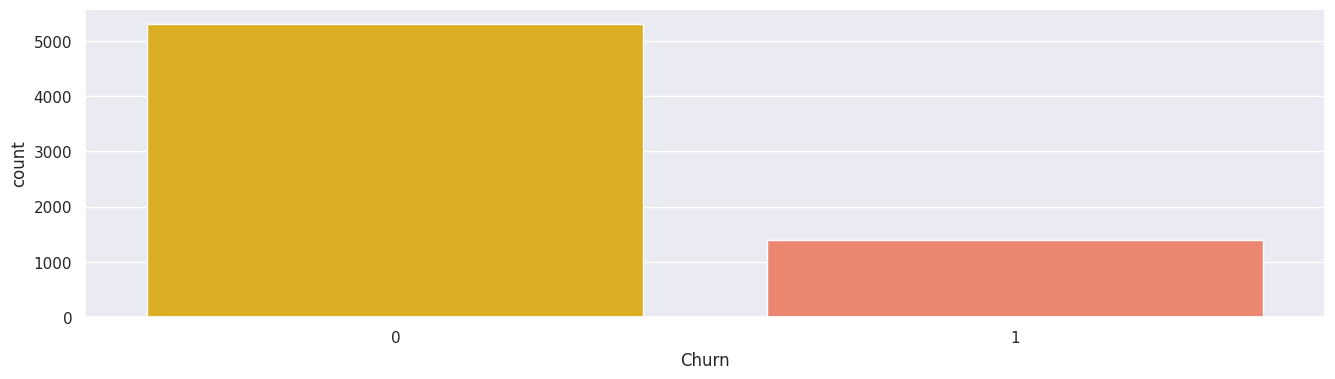

In [129]:
# Visualizando proporção da variável resposta
sns.countplot(x= y_train);

- Como a variável resposta está desbalanceada, aplico uma técnica (algoritmo) que irá balancear os dados e evitar enviesamento do modelo.

In [130]:
# Over-Sampling na variável resposta dos dados de treino 
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

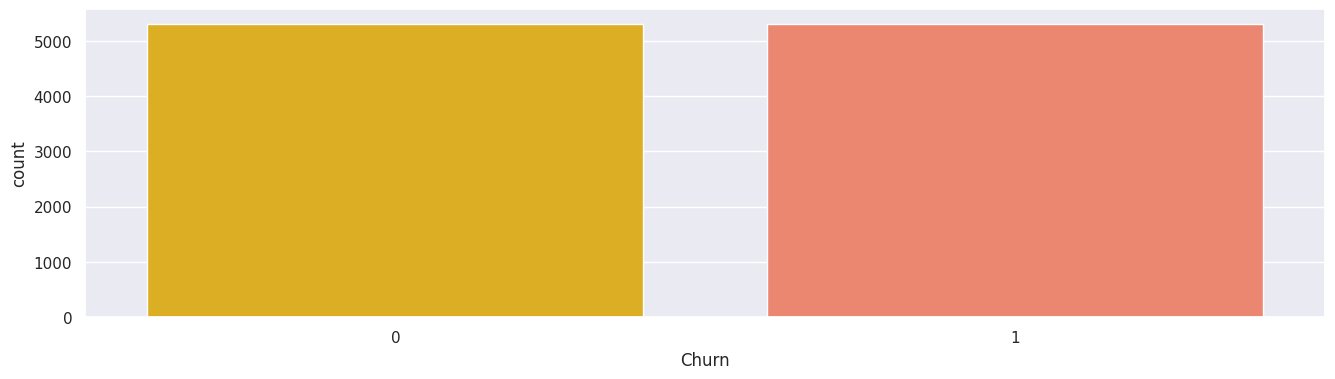

In [131]:
# Visualizando proporção da variável resposta
sns.countplot(x= y_train);

## Note:

- Ao escalar os dados usa-se métricas que são definidas por todo o conjunto de dados, então decidi dividir os dados de treino e teste antes de escalar, pois assim, eu teria dois conjuntos de dados, com métricas únicas para cada conjunto, anulando o enviesamento do modelo. 
		Ex.: A normalização MinMaxScaler utiliza o valor mínimo e máximo do conjunto de dados. Se a normalização tivesse sido feita antes da divisão dos dados em conjuntos de treino e teste, a normalização dos dois conjuntos teriam o mesmo padrão escalar, de um único conjunto, pois iriam dividir os elementos mínimos e máximo, logo estaria injetando informações futuras no conjunto de dados de treinamneto, e assim, enviesando o modelo. Com normalização realizada depois da divisão dos dados em treino e teste, os valores mínimo e máximo seriam únicos para cada conjunto, assim, isolando os dados de treino com os dados de teste, evitando o enviesamento do modelo.

# Feature Selection

In [132]:
df6 = df5.copy()

## Boruta Feature Selector

In [133]:
X_train_boruta= X_train.values
y_train_boruta = y_train.values

In [134]:
# Instanciando RandomForestRegressor
random_forest = RandomForestClassifier(n_estimators= 100, n_jobs= -1, random_state= 42)

# Instanciando Boruta
boruta = BorutaPy(random_forest, verbose= 2, random_state= 42).fit(X_train_boruta, y_train_boruta)

### Best Features from Boruta 

In [135]:
features_selected = boruta.support_.tolist()

features_selected_boruta = X_train.iloc[:, features_selected].columns.to_list()

features_not_selected_boruta = list(np.setdiff1d(X_train.columns, features_selected_boruta))

In [136]:
features_selected_boruta

In [137]:
features_not_selected_boruta

In [138]:
variables_selected_eda = ['idade', 'saldo', 'salario_estimado', 'geografia', 'genero', 'membro_ativo']

variables_not_selected_eda = ['score_credito', 'LTV_medio', 'tempo_permanencia', 'numero_de_contas', 'tem_cartao_credito', 'escala_fico']

features_selected_boruta = ['score_credito',
 'genero',
 'idade',
 'tempo_permanencia',
 'saldo',
 'numero_de_contas',
 'membro_ativo',
 'salario_estimado',
 'LTV_medio',
 'taxa_saldo_por_salario',
 'score_credito_por_idade',
 'taxa_tempo_permanencia_por_idade',
 'taxa_numero_contas_por_idade',
 'saldo_por_idade',
 'salario_por_idade',
 'media_saldo_por_idade',
 'media_salarial_por_idade',
 'media_saldo_por_geografia']

features_not_selected_boruta = ['escala_fico',
 'geografia',
 'media_salarial_por_geografia',
 'tem_cartao_credito']

#########################################

features_selected = ['genero',
 'idade',
 'saldo',
 'membro_ativo',
 'salario_estimado',
 'geografia',                    
 'taxa_saldo_por_salario',
 'score_credito_por_idade',
 'taxa_tempo_permanencia_por_idade',
 'taxa_numero_contas_por_idade',
 'saldo_por_idade',
 'salario_por_idade',
 'media_saldo_por_idade',
 'media_salarial_por_idade',
 'media_saldo_por_geografia']

features_not_selected = ['score_credito', 
                         'LTV_medio', 
                         'tempo_permanencia', 
                         'numero_de_contas', 
                         'tem_cartao_credito',
                         'escala_fico',
                         'tem_cartao_credito',
                         'media_salarial_por_geografia']

#Junção das colunas selecionadas pela análise exploratória e pelo boruta, dando prioridade para análise exploratória

# Conjunto de dados que possui a melhor performance até o momento

best_features = ['score_credito',
 'geografia',
 'genero',
 'idade',
 'saldo',
 'numero_de_contas',
 'membro_ativo',
 'LTV_medio',
 'taxa_saldo_por_salario',
 'score_credito_por_idade',
 'taxa_tempo_permanencia_por_idade',
 'taxa_numero_contas_por_idade', 
 'saldo_por_idade',
 'salario_por_idade',
 'salario_estimado']


# Machine Learning and Model Metrics 

In [139]:
df7 = df6.copy()

## Filtering Data Selecting Best Features to Model

In [140]:
X_train_model = X_train[best_features]
y_train_model = y_train

X_test_model = X_test[best_features]
y_test_model = y_test

In [141]:
X_train_model.sample(5)

,score_credito,geografia,genero,idade,saldo,numero_de_contas,membro_ativo,LTV_medio,taxa_saldo_por_salario,score_credito_por_idade,taxa_tempo_permanencia_por_idade,taxa_numero_contas_por_idade,saldo_por_idade,salario_por_idade,salario_estimado
762,0.760000,0,1,-0.833333,0.000000,1.000000,1,0.500000,-0.497632,1.397764,0.418447,1.266667,0.000000,0.392105,0.580306
4611,0.564000,2,1,0.833333,0.000000,1.000000,0,-0.166667,-0.497632,-0.559832,-0.472756,0.188652,0.000000,0.346980,0.894195
1904,0.358000,2,1,-0.166667,0.381721,0.000000,1,-0.333333,0.075450,-0.319641,0.107601,-0.289524,0.267979,0.293845,0.563794
6487,0.990000,1,0,0.333333,0.325765,1.000000,0,-0.500000,-0.221510,0.471950,-0.583275,0.401626,0.195228,0.444372,0.998952
10031,0.548179,1,0,1.661381,0.480545,0.645524,0,-0.462063,1.337899,-0.916240,-0.648974,-0.284974,0.207605,0.083482,0.257642


In [142]:
X_test_model.sample(5)

,score_credito,geografia,genero,idade,saldo,numero_de_contas,membro_ativo,LTV_medio,taxa_saldo_por_salario,score_credito_por_idade,taxa_tempo_permanencia_por_idade,taxa_numero_contas_por_idade,saldo_por_idade,salario_por_idade,salario_estimado
640,0.362,2,0,-0.083333,0.395541,0.0,0,0.333333,0.046259,-0.372115,0.894431,-0.316667,0.269968,0.311923,0.615602
1307,0.586,1,1,1.833333,0.678887,0.0,1,-0.666667,3.075353,-0.926930,-0.568095,-0.687006,0.282727,0.049607,0.160504
741,0.664,0,1,0.916667,0.553126,0.0,1,-1.000000,0.057066,-0.450139,-0.788512,-0.554167,0.283143,0.320775,0.844255
1674,0.654,2,1,-1.583333,0.537257,1.0,1,1.500000,0.294371,2.920900,2.322382,2.533333,0.733386,0.582029,0.574187
2538,1.000,0,0,0.333333,0.000000,1.0,1,0.500000,-0.497632,0.489517,-0.045927,0.401626,0.000000,0.077357,0.173790


## Cross Validation

### Random Forest

In [143]:
kfold = KFold(5, shuffle= True, random_state= 42)

random_forest_cv = RandomForestClassifier(n_estimators= 150, n_jobs= -1, random_state= 42)

accuracy_rf = cross_val_score(random_forest_cv, X_train_model, y_train_model, cv= kfold)

print(f'Acurácia (Cross Validation): {round(accuracy_rf.mean(), 2)} +/-{round(accuracy_rf.std(), 2)}')

Acurácia (Cross Validation): 0.88 +/-0.01


### XGB

In [144]:
kfold = KFold(5, shuffle= True, random_state= 42)

xg_boost_cv = XGBClassifier(random_state= 42, n_jobs= -1)

accuracy_xgb = cross_val_score(xg_boost_cv, X_train_model, y_train_model, cv= kfold)

print(f'Acurácia (Cross Validation): {round(accuracy_xgb.mean(), 2)} +/-{round(accuracy_xgb.std(), 2)}')

Acurácia (Cross Validation): 0.9 +/-0.01


### CatBoost

In [145]:
kfold = KFold(5, shuffle= True, random_state= 42)

cat_boost_cv = CatBoostClassifier(random_state = 42, allow_writing_files=False)

accuracy_cb = cross_val_score(cat_boost_cv, X_train_model, y_train_model, cv= kfold)

Learning rate set to 0.025678
0:	learn: 0.6773787	total: 63.8ms	remaining: 1m 3s
1:	learn: 0.6614167	total: 69.3ms	remaining: 34.6s
2:	learn: 0.6472398	total: 74.3ms	remaining: 24.7s
3:	learn: 0.6333111	total: 95.2ms	remaining: 23.7s
4:	learn: 0.6216731	total: 108ms	remaining: 21.5s
5:	learn: 0.6091550	total: 113ms	remaining: 18.7s
6:	learn: 0.5975515	total: 120ms	remaining: 17s
7:	learn: 0.5869526	total: 126ms	remaining: 15.6s
8:	learn: 0.5765582	total: 133ms	remaining: 14.6s
9:	learn: 0.5671475	total: 140ms	remaining: 13.8s
10:	learn: 0.5585839	total: 145ms	remaining: 13s
11:	learn: 0.5495959	total: 152ms	remaining: 12.5s
12:	learn: 0.5436231	total: 157ms	remaining: 11.9s
13:	learn: 0.5369514	total: 162ms	remaining: 11.4s
14:	learn: 0.5305942	total: 190ms	remaining: 12.5s
15:	learn: 0.5235757	total: 197ms	remaining: 12.1s
16:	learn: 0.5177828	total: 201ms	remaining: 11.6s
17:	learn: 0.5124589	total: 206ms	remaining: 11.2s
18:	learn: 0.5063708	total: 217ms	remaining: 11.2s
19:	learn: 

178:	learn: 0.3361275	total: 925ms	remaining: 4.24s
179:	learn: 0.3357543	total: 929ms	remaining: 4.23s
180:	learn: 0.3354733	total: 933ms	remaining: 4.22s
181:	learn: 0.3350851	total: 937ms	remaining: 4.21s
182:	learn: 0.3343187	total: 941ms	remaining: 4.2s
183:	learn: 0.3338210	total: 946ms	remaining: 4.19s
184:	learn: 0.3334284	total: 950ms	remaining: 4.18s
185:	learn: 0.3330716	total: 954ms	remaining: 4.17s
186:	learn: 0.3327925	total: 958ms	remaining: 4.17s
187:	learn: 0.3325994	total: 962ms	remaining: 4.16s
188:	learn: 0.3322221	total: 967ms	remaining: 4.15s
189:	learn: 0.3318234	total: 971ms	remaining: 4.14s
190:	learn: 0.3316121	total: 975ms	remaining: 4.13s
191:	learn: 0.3314170	total: 979ms	remaining: 4.12s
192:	learn: 0.3310250	total: 983ms	remaining: 4.11s
193:	learn: 0.3305154	total: 987ms	remaining: 4.1s
194:	learn: 0.3302489	total: 992ms	remaining: 4.09s
195:	learn: 0.3298539	total: 996ms	remaining: 4.08s
196:	learn: 0.3296250	total: 1s	remaining: 4.08s
197:	learn: 0.329

338:	learn: 0.2820678	total: 1.61s	remaining: 3.13s
339:	learn: 0.2815612	total: 1.61s	remaining: 3.13s
340:	learn: 0.2813302	total: 1.61s	remaining: 3.12s
341:	learn: 0.2811298	total: 1.62s	remaining: 3.12s
342:	learn: 0.2806331	total: 1.63s	remaining: 3.12s
343:	learn: 0.2804258	total: 1.63s	remaining: 3.11s
344:	learn: 0.2802069	total: 1.64s	remaining: 3.1s
345:	learn: 0.2799177	total: 1.64s	remaining: 3.1s
346:	learn: 0.2797904	total: 1.64s	remaining: 3.09s
347:	learn: 0.2791069	total: 1.65s	remaining: 3.09s
348:	learn: 0.2789646	total: 1.65s	remaining: 3.08s
349:	learn: 0.2785295	total: 1.66s	remaining: 3.08s
350:	learn: 0.2783169	total: 1.66s	remaining: 3.07s
351:	learn: 0.2781580	total: 1.67s	remaining: 3.06s
352:	learn: 0.2779192	total: 1.67s	remaining: 3.06s
353:	learn: 0.2777363	total: 1.67s	remaining: 3.05s
354:	learn: 0.2776577	total: 1.68s	remaining: 3.05s
355:	learn: 0.2775187	total: 1.68s	remaining: 3.04s
356:	learn: 0.2772812	total: 1.68s	remaining: 3.03s
357:	learn: 0.

509:	learn: 0.2351705	total: 2.33s	remaining: 2.24s
510:	learn: 0.2349807	total: 2.34s	remaining: 2.24s
511:	learn: 0.2348589	total: 2.34s	remaining: 2.23s
512:	learn: 0.2347718	total: 2.35s	remaining: 2.23s
513:	learn: 0.2344938	total: 2.35s	remaining: 2.22s
514:	learn: 0.2343737	total: 2.36s	remaining: 2.22s
515:	learn: 0.2341747	total: 2.36s	remaining: 2.21s
516:	learn: 0.2340401	total: 2.37s	remaining: 2.21s
517:	learn: 0.2338665	total: 2.37s	remaining: 2.21s
518:	learn: 0.2336971	total: 2.37s	remaining: 2.2s
519:	learn: 0.2335001	total: 2.38s	remaining: 2.19s
520:	learn: 0.2334149	total: 2.38s	remaining: 2.19s
521:	learn: 0.2332984	total: 2.39s	remaining: 2.19s
522:	learn: 0.2331561	total: 2.39s	remaining: 2.18s
523:	learn: 0.2329023	total: 2.4s	remaining: 2.17s
524:	learn: 0.2326890	total: 2.4s	remaining: 2.17s
525:	learn: 0.2325952	total: 2.4s	remaining: 2.17s
526:	learn: 0.2324350	total: 2.41s	remaining: 2.16s
527:	learn: 0.2322903	total: 2.41s	remaining: 2.16s
528:	learn: 0.23

669:	learn: 0.2104774	total: 3.01s	remaining: 1.48s
670:	learn: 0.2103765	total: 3.02s	remaining: 1.48s
671:	learn: 0.2102568	total: 3.02s	remaining: 1.48s
672:	learn: 0.2101657	total: 3.03s	remaining: 1.47s
673:	learn: 0.2100936	total: 3.03s	remaining: 1.47s
674:	learn: 0.2099463	total: 3.04s	remaining: 1.46s
675:	learn: 0.2095841	total: 3.04s	remaining: 1.46s
676:	learn: 0.2095028	total: 3.05s	remaining: 1.45s
677:	learn: 0.2094441	total: 3.05s	remaining: 1.45s
678:	learn: 0.2092796	total: 3.05s	remaining: 1.44s
679:	learn: 0.2091208	total: 3.06s	remaining: 1.44s
680:	learn: 0.2089761	total: 3.06s	remaining: 1.43s
681:	learn: 0.2088462	total: 3.07s	remaining: 1.43s
682:	learn: 0.2087660	total: 3.07s	remaining: 1.43s
683:	learn: 0.2086461	total: 3.07s	remaining: 1.42s
684:	learn: 0.2085180	total: 3.08s	remaining: 1.42s
685:	learn: 0.2083744	total: 3.08s	remaining: 1.41s
686:	learn: 0.2082363	total: 3.09s	remaining: 1.41s
687:	learn: 0.2081356	total: 3.09s	remaining: 1.4s
688:	learn: 0

835:	learn: 0.1908077	total: 3.74s	remaining: 734ms
836:	learn: 0.1907087	total: 3.74s	remaining: 729ms
837:	learn: 0.1906059	total: 3.75s	remaining: 725ms
838:	learn: 0.1904638	total: 3.76s	remaining: 721ms
839:	learn: 0.1903774	total: 3.76s	remaining: 716ms
840:	learn: 0.1903034	total: 3.76s	remaining: 712ms
841:	learn: 0.1901935	total: 3.77s	remaining: 707ms
842:	learn: 0.1899022	total: 3.77s	remaining: 703ms
843:	learn: 0.1897965	total: 3.78s	remaining: 698ms
844:	learn: 0.1896851	total: 3.78s	remaining: 694ms
845:	learn: 0.1896322	total: 3.79s	remaining: 689ms
846:	learn: 0.1895389	total: 3.79s	remaining: 684ms
847:	learn: 0.1893938	total: 3.79s	remaining: 680ms
848:	learn: 0.1892726	total: 3.8s	remaining: 675ms
849:	learn: 0.1890659	total: 3.8s	remaining: 671ms
850:	learn: 0.1889612	total: 3.81s	remaining: 666ms
851:	learn: 0.1888537	total: 3.81s	remaining: 662ms
852:	learn: 0.1887728	total: 3.82s	remaining: 658ms
853:	learn: 0.1886179	total: 3.82s	remaining: 653ms
854:	learn: 0.

6:	learn: 0.5922205	total: 41.6ms	remaining: 5.9s
7:	learn: 0.5819384	total: 49ms	remaining: 6.07s
8:	learn: 0.5730169	total: 54.3ms	remaining: 5.97s
9:	learn: 0.5624853	total: 60.3ms	remaining: 5.97s
10:	learn: 0.5535830	total: 67.3ms	remaining: 6.05s
11:	learn: 0.5466184	total: 72.1ms	remaining: 5.93s
12:	learn: 0.5408276	total: 77.3ms	remaining: 5.87s
13:	learn: 0.5333490	total: 82.2ms	remaining: 5.79s
14:	learn: 0.5271735	total: 86.6ms	remaining: 5.69s
15:	learn: 0.5203776	total: 91.5ms	remaining: 5.63s
16:	learn: 0.5144692	total: 96.8ms	remaining: 5.6s
17:	learn: 0.5087946	total: 101ms	remaining: 5.53s
18:	learn: 0.5035082	total: 107ms	remaining: 5.52s
19:	learn: 0.4979661	total: 112ms	remaining: 5.48s
20:	learn: 0.4946990	total: 118ms	remaining: 5.48s
21:	learn: 0.4906300	total: 123ms	remaining: 5.48s
22:	learn: 0.4861763	total: 128ms	remaining: 5.42s
23:	learn: 0.4826296	total: 131ms	remaining: 5.34s
24:	learn: 0.4781940	total: 135ms	remaining: 5.27s
25:	learn: 0.4748129	total: 

187:	learn: 0.3349246	total: 839ms	remaining: 3.62s
188:	learn: 0.3346749	total: 845ms	remaining: 3.62s
189:	learn: 0.3342318	total: 849ms	remaining: 3.62s
190:	learn: 0.3335038	total: 855ms	remaining: 3.62s
191:	learn: 0.3332633	total: 860ms	remaining: 3.62s
192:	learn: 0.3327769	total: 864ms	remaining: 3.61s
193:	learn: 0.3325574	total: 868ms	remaining: 3.61s
194:	learn: 0.3322925	total: 873ms	remaining: 3.6s
195:	learn: 0.3318910	total: 878ms	remaining: 3.6s
196:	learn: 0.3316090	total: 882ms	remaining: 3.59s
197:	learn: 0.3313475	total: 887ms	remaining: 3.59s
198:	learn: 0.3306445	total: 891ms	remaining: 3.59s
199:	learn: 0.3302710	total: 895ms	remaining: 3.58s
200:	learn: 0.3296910	total: 899ms	remaining: 3.57s
201:	learn: 0.3293207	total: 904ms	remaining: 3.57s
202:	learn: 0.3289004	total: 908ms	remaining: 3.57s
203:	learn: 0.3285693	total: 913ms	remaining: 3.56s
204:	learn: 0.3282923	total: 917ms	remaining: 3.56s
205:	learn: 0.3280948	total: 921ms	remaining: 3.55s
206:	learn: 0.

374:	learn: 0.2728339	total: 1.64s	remaining: 2.73s
375:	learn: 0.2725982	total: 1.65s	remaining: 2.73s
376:	learn: 0.2721488	total: 1.65s	remaining: 2.73s
377:	learn: 0.2712695	total: 1.66s	remaining: 2.72s
378:	learn: 0.2711309	total: 1.66s	remaining: 2.72s
379:	learn: 0.2710218	total: 1.66s	remaining: 2.71s
380:	learn: 0.2708080	total: 1.67s	remaining: 2.71s
381:	learn: 0.2702431	total: 1.67s	remaining: 2.71s
382:	learn: 0.2701249	total: 1.68s	remaining: 2.7s
383:	learn: 0.2699514	total: 1.68s	remaining: 2.7s
384:	learn: 0.2697509	total: 1.68s	remaining: 2.69s
385:	learn: 0.2695007	total: 1.69s	remaining: 2.69s
386:	learn: 0.2683897	total: 1.69s	remaining: 2.68s
387:	learn: 0.2678155	total: 1.7s	remaining: 2.68s
388:	learn: 0.2676112	total: 1.7s	remaining: 2.67s
389:	learn: 0.2672770	total: 1.71s	remaining: 2.67s
390:	learn: 0.2671223	total: 1.71s	remaining: 2.66s
391:	learn: 0.2669223	total: 1.71s	remaining: 2.66s
392:	learn: 0.2667966	total: 1.72s	remaining: 2.65s
393:	learn: 0.26

561:	learn: 0.2273582	total: 2.45s	remaining: 1.91s
562:	learn: 0.2271884	total: 2.45s	remaining: 1.9s
563:	learn: 0.2271056	total: 2.45s	remaining: 1.9s
564:	learn: 0.2269756	total: 2.46s	remaining: 1.89s
565:	learn: 0.2268750	total: 2.46s	remaining: 1.89s
566:	learn: 0.2267806	total: 2.47s	remaining: 1.88s
567:	learn: 0.2266979	total: 2.47s	remaining: 1.88s
568:	learn: 0.2266249	total: 2.48s	remaining: 1.88s
569:	learn: 0.2265230	total: 2.48s	remaining: 1.87s
570:	learn: 0.2263851	total: 2.48s	remaining: 1.87s
571:	learn: 0.2262364	total: 2.49s	remaining: 1.86s
572:	learn: 0.2258508	total: 2.49s	remaining: 1.86s
573:	learn: 0.2257767	total: 2.5s	remaining: 1.85s
574:	learn: 0.2255716	total: 2.5s	remaining: 1.85s
575:	learn: 0.2254530	total: 2.5s	remaining: 1.84s
576:	learn: 0.2253643	total: 2.51s	remaining: 1.84s
577:	learn: 0.2252293	total: 2.51s	remaining: 1.83s
578:	learn: 0.2251076	total: 2.52s	remaining: 1.83s
579:	learn: 0.2249767	total: 2.52s	remaining: 1.83s
580:	learn: 0.224

741:	learn: 0.2027678	total: 3.25s	remaining: 1.13s
742:	learn: 0.2026991	total: 3.25s	remaining: 1.12s
743:	learn: 0.2026088	total: 3.25s	remaining: 1.12s
744:	learn: 0.2024818	total: 3.26s	remaining: 1.11s
745:	learn: 0.2021693	total: 3.26s	remaining: 1.11s
746:	learn: 0.2019027	total: 3.27s	remaining: 1.11s
747:	learn: 0.2018180	total: 3.27s	remaining: 1.1s
748:	learn: 0.2016250	total: 3.28s	remaining: 1.1s
749:	learn: 0.2015098	total: 3.28s	remaining: 1.09s
750:	learn: 0.2014097	total: 3.29s	remaining: 1.09s
751:	learn: 0.2012746	total: 3.29s	remaining: 1.08s
752:	learn: 0.2011278	total: 3.29s	remaining: 1.08s
753:	learn: 0.2010445	total: 3.3s	remaining: 1.08s
754:	learn: 0.2008579	total: 3.3s	remaining: 1.07s
755:	learn: 0.2007155	total: 3.31s	remaining: 1.07s
756:	learn: 0.2006240	total: 3.31s	remaining: 1.06s
757:	learn: 0.2004890	total: 3.32s	remaining: 1.06s
758:	learn: 0.2004147	total: 3.32s	remaining: 1.05s
759:	learn: 0.2003706	total: 3.33s	remaining: 1.05s
760:	learn: 0.20

903:	learn: 0.1853556	total: 3.93s	remaining: 418ms
904:	learn: 0.1853098	total: 3.94s	remaining: 413ms
905:	learn: 0.1852053	total: 3.94s	remaining: 409ms
906:	learn: 0.1851359	total: 3.94s	remaining: 405ms
907:	learn: 0.1850221	total: 3.95s	remaining: 400ms
908:	learn: 0.1849001	total: 3.96s	remaining: 396ms
909:	learn: 0.1847999	total: 3.96s	remaining: 392ms
910:	learn: 0.1846491	total: 3.96s	remaining: 387ms
911:	learn: 0.1845495	total: 3.97s	remaining: 383ms
912:	learn: 0.1844091	total: 3.97s	remaining: 379ms
913:	learn: 0.1843327	total: 3.98s	remaining: 374ms
914:	learn: 0.1842946	total: 3.98s	remaining: 370ms
915:	learn: 0.1842147	total: 3.98s	remaining: 365ms
916:	learn: 0.1841360	total: 3.99s	remaining: 361ms
917:	learn: 0.1840643	total: 3.99s	remaining: 357ms
918:	learn: 0.1839948	total: 4s	remaining: 352ms
919:	learn: 0.1839296	total: 4s	remaining: 348ms
920:	learn: 0.1838478	total: 4s	remaining: 344ms
921:	learn: 0.1838030	total: 4.01s	remaining: 339ms
922:	learn: 0.1837011

79:	learn: 0.3961809	total: 367ms	remaining: 4.22s
80:	learn: 0.3952358	total: 371ms	remaining: 4.21s
81:	learn: 0.3945267	total: 375ms	remaining: 4.2s
82:	learn: 0.3939960	total: 380ms	remaining: 4.2s
83:	learn: 0.3926714	total: 384ms	remaining: 4.19s
84:	learn: 0.3919690	total: 388ms	remaining: 4.18s
85:	learn: 0.3915335	total: 392ms	remaining: 4.17s
86:	learn: 0.3908671	total: 396ms	remaining: 4.16s
87:	learn: 0.3901296	total: 401ms	remaining: 4.15s
88:	learn: 0.3894785	total: 405ms	remaining: 4.15s
89:	learn: 0.3889646	total: 409ms	remaining: 4.14s
90:	learn: 0.3884431	total: 413ms	remaining: 4.12s
91:	learn: 0.3878848	total: 417ms	remaining: 4.11s
92:	learn: 0.3869063	total: 421ms	remaining: 4.1s
93:	learn: 0.3861410	total: 424ms	remaining: 4.09s
94:	learn: 0.3854389	total: 429ms	remaining: 4.08s
95:	learn: 0.3846448	total: 433ms	remaining: 4.08s
96:	learn: 0.3841253	total: 437ms	remaining: 4.07s
97:	learn: 0.3836755	total: 441ms	remaining: 4.06s
98:	learn: 0.3832512	total: 445ms	

249:	learn: 0.3171985	total: 1.09s	remaining: 3.28s
250:	learn: 0.3169913	total: 1.1s	remaining: 3.27s
251:	learn: 0.3167691	total: 1.1s	remaining: 3.27s
252:	learn: 0.3164659	total: 1.11s	remaining: 3.27s
253:	learn: 0.3162752	total: 1.11s	remaining: 3.26s
254:	learn: 0.3161381	total: 1.11s	remaining: 3.26s
255:	learn: 0.3149528	total: 1.12s	remaining: 3.26s
256:	learn: 0.3147090	total: 1.12s	remaining: 3.25s
257:	learn: 0.3145097	total: 1.13s	remaining: 3.25s
258:	learn: 0.3142572	total: 1.13s	remaining: 3.24s
259:	learn: 0.3139538	total: 1.14s	remaining: 3.24s
260:	learn: 0.3134179	total: 1.14s	remaining: 3.23s
261:	learn: 0.3132005	total: 1.15s	remaining: 3.23s
262:	learn: 0.3122744	total: 1.15s	remaining: 3.22s
263:	learn: 0.3121021	total: 1.15s	remaining: 3.22s
264:	learn: 0.3118851	total: 1.16s	remaining: 3.21s
265:	learn: 0.3117687	total: 1.16s	remaining: 3.21s
266:	learn: 0.3112297	total: 1.17s	remaining: 3.2s
267:	learn: 0.3108618	total: 1.17s	remaining: 3.2s
268:	learn: 0.31

409:	learn: 0.2663914	total: 1.77s	remaining: 2.55s
410:	learn: 0.2662059	total: 1.78s	remaining: 2.55s
411:	learn: 0.2660352	total: 1.78s	remaining: 2.54s
412:	learn: 0.2658320	total: 1.78s	remaining: 2.54s
413:	learn: 0.2656399	total: 1.79s	remaining: 2.53s
414:	learn: 0.2653712	total: 1.79s	remaining: 2.53s
415:	learn: 0.2651826	total: 1.8s	remaining: 2.52s
416:	learn: 0.2648957	total: 1.8s	remaining: 2.52s
417:	learn: 0.2645391	total: 1.81s	remaining: 2.51s
418:	learn: 0.2643219	total: 1.81s	remaining: 2.51s
419:	learn: 0.2634407	total: 1.81s	remaining: 2.5s
420:	learn: 0.2633014	total: 1.82s	remaining: 2.5s
421:	learn: 0.2632071	total: 1.82s	remaining: 2.5s
422:	learn: 0.2628953	total: 1.83s	remaining: 2.49s
423:	learn: 0.2625363	total: 1.83s	remaining: 2.49s
424:	learn: 0.2619751	total: 1.83s	remaining: 2.48s
425:	learn: 0.2615256	total: 1.84s	remaining: 2.48s
426:	learn: 0.2610028	total: 1.84s	remaining: 2.47s
427:	learn: 0.2607599	total: 1.85s	remaining: 2.47s
428:	learn: 0.260

580:	learn: 0.2306758	total: 2.5s	remaining: 1.8s
581:	learn: 0.2305474	total: 2.5s	remaining: 1.8s
582:	learn: 0.2300811	total: 2.51s	remaining: 1.79s
583:	learn: 0.2299194	total: 2.51s	remaining: 1.79s
584:	learn: 0.2297055	total: 2.52s	remaining: 1.79s
585:	learn: 0.2295726	total: 2.52s	remaining: 1.78s
586:	learn: 0.2294124	total: 2.53s	remaining: 1.78s
587:	learn: 0.2292513	total: 2.53s	remaining: 1.77s
588:	learn: 0.2290490	total: 2.54s	remaining: 1.77s
589:	learn: 0.2289056	total: 2.54s	remaining: 1.76s
590:	learn: 0.2287461	total: 2.54s	remaining: 1.76s
591:	learn: 0.2286222	total: 2.55s	remaining: 1.76s
592:	learn: 0.2284910	total: 2.55s	remaining: 1.75s
593:	learn: 0.2283341	total: 2.56s	remaining: 1.75s
594:	learn: 0.2281916	total: 2.56s	remaining: 1.74s
595:	learn: 0.2280766	total: 2.56s	remaining: 1.74s
596:	learn: 0.2278956	total: 2.57s	remaining: 1.73s
597:	learn: 0.2277153	total: 2.57s	remaining: 1.73s
598:	learn: 0.2275746	total: 2.58s	remaining: 1.73s
599:	learn: 0.22

740:	learn: 0.2076611	total: 3.18s	remaining: 1.11s
741:	learn: 0.2075695	total: 3.18s	remaining: 1.11s
742:	learn: 0.2074612	total: 3.19s	remaining: 1.1s
743:	learn: 0.2072469	total: 3.19s	remaining: 1.1s
744:	learn: 0.2071372	total: 3.19s	remaining: 1.09s
745:	learn: 0.2070200	total: 3.2s	remaining: 1.09s
746:	learn: 0.2068737	total: 3.2s	remaining: 1.08s
747:	learn: 0.2067462	total: 3.21s	remaining: 1.08s
748:	learn: 0.2066855	total: 3.21s	remaining: 1.08s
749:	learn: 0.2066051	total: 3.22s	remaining: 1.07s
750:	learn: 0.2064636	total: 3.22s	remaining: 1.07s
751:	learn: 0.2063826	total: 3.22s	remaining: 1.06s
752:	learn: 0.2062456	total: 3.23s	remaining: 1.06s
753:	learn: 0.2061732	total: 3.23s	remaining: 1.05s
754:	learn: 0.2060071	total: 3.24s	remaining: 1.05s
755:	learn: 0.2059599	total: 3.24s	remaining: 1.04s
756:	learn: 0.2058049	total: 3.24s	remaining: 1.04s
757:	learn: 0.2056990	total: 3.25s	remaining: 1.04s
758:	learn: 0.2054292	total: 3.25s	remaining: 1.03s
759:	learn: 0.20

912:	learn: 0.1882430	total: 3.9s	remaining: 372ms
913:	learn: 0.1881686	total: 3.9s	remaining: 367ms
914:	learn: 0.1880659	total: 3.91s	remaining: 363ms
915:	learn: 0.1879425	total: 3.91s	remaining: 359ms
916:	learn: 0.1878361	total: 3.92s	remaining: 355ms
917:	learn: 0.1877569	total: 3.92s	remaining: 350ms
918:	learn: 0.1876110	total: 3.93s	remaining: 346ms
919:	learn: 0.1874811	total: 3.93s	remaining: 342ms
920:	learn: 0.1873904	total: 3.94s	remaining: 338ms
921:	learn: 0.1872890	total: 3.94s	remaining: 333ms
922:	learn: 0.1871995	total: 3.94s	remaining: 329ms
923:	learn: 0.1871103	total: 3.95s	remaining: 325ms
924:	learn: 0.1870620	total: 3.95s	remaining: 321ms
925:	learn: 0.1870164	total: 3.96s	remaining: 316ms
926:	learn: 0.1869024	total: 3.96s	remaining: 312ms
927:	learn: 0.1866353	total: 3.96s	remaining: 308ms
928:	learn: 0.1865449	total: 3.97s	remaining: 303ms
929:	learn: 0.1863936	total: 3.97s	remaining: 299ms
930:	learn: 0.1862604	total: 3.98s	remaining: 295ms
931:	learn: 0.

93:	learn: 0.3834656	total: 417ms	remaining: 4.02s
94:	learn: 0.3824718	total: 422ms	remaining: 4.02s
95:	learn: 0.3817424	total: 427ms	remaining: 4.02s
96:	learn: 0.3809533	total: 432ms	remaining: 4.02s
97:	learn: 0.3805078	total: 436ms	remaining: 4.02s
98:	learn: 0.3796851	total: 440ms	remaining: 4.01s
99:	learn: 0.3789475	total: 447ms	remaining: 4.02s
100:	learn: 0.3782002	total: 452ms	remaining: 4.02s
101:	learn: 0.3774964	total: 456ms	remaining: 4.01s
102:	learn: 0.3767484	total: 460ms	remaining: 4.01s
103:	learn: 0.3762090	total: 464ms	remaining: 4s
104:	learn: 0.3756028	total: 469ms	remaining: 3.99s
105:	learn: 0.3751024	total: 473ms	remaining: 3.99s
106:	learn: 0.3741671	total: 477ms	remaining: 3.98s
107:	learn: 0.3736026	total: 481ms	remaining: 3.97s
108:	learn: 0.3730200	total: 485ms	remaining: 3.97s
109:	learn: 0.3724485	total: 490ms	remaining: 3.96s
110:	learn: 0.3719429	total: 494ms	remaining: 3.96s
111:	learn: 0.3714891	total: 499ms	remaining: 3.96s
112:	learn: 0.3710350	

277:	learn: 0.3061420	total: 1.22s	remaining: 3.16s
278:	learn: 0.3057349	total: 1.22s	remaining: 3.16s
279:	learn: 0.3055269	total: 1.23s	remaining: 3.16s
280:	learn: 0.3053180	total: 1.23s	remaining: 3.15s
281:	learn: 0.3051744	total: 1.24s	remaining: 3.15s
282:	learn: 0.3047367	total: 1.24s	remaining: 3.14s
283:	learn: 0.3045893	total: 1.24s	remaining: 3.14s
284:	learn: 0.3043583	total: 1.25s	remaining: 3.13s
285:	learn: 0.3037658	total: 1.25s	remaining: 3.13s
286:	learn: 0.3035273	total: 1.26s	remaining: 3.13s
287:	learn: 0.3029411	total: 1.26s	remaining: 3.12s
288:	learn: 0.3026716	total: 1.27s	remaining: 3.12s
289:	learn: 0.3023851	total: 1.27s	remaining: 3.11s
290:	learn: 0.3020685	total: 1.27s	remaining: 3.11s
291:	learn: 0.3015870	total: 1.28s	remaining: 3.1s
292:	learn: 0.3010693	total: 1.28s	remaining: 3.1s
293:	learn: 0.3008722	total: 1.29s	remaining: 3.09s
294:	learn: 0.3006689	total: 1.29s	remaining: 3.09s
295:	learn: 0.2999332	total: 1.3s	remaining: 3.08s
296:	learn: 0.2

438:	learn: 0.2594647	total: 1.91s	remaining: 2.44s
439:	learn: 0.2593106	total: 1.91s	remaining: 2.43s
440:	learn: 0.2588356	total: 1.92s	remaining: 2.43s
441:	learn: 0.2587062	total: 1.92s	remaining: 2.43s
442:	learn: 0.2585528	total: 1.93s	remaining: 2.42s
443:	learn: 0.2584423	total: 1.93s	remaining: 2.42s
444:	learn: 0.2582320	total: 1.94s	remaining: 2.41s
445:	learn: 0.2575988	total: 1.94s	remaining: 2.41s
446:	learn: 0.2573456	total: 1.94s	remaining: 2.4s
447:	learn: 0.2571647	total: 1.95s	remaining: 2.4s
448:	learn: 0.2570073	total: 1.95s	remaining: 2.4s
449:	learn: 0.2569237	total: 1.96s	remaining: 2.39s
450:	learn: 0.2561867	total: 1.96s	remaining: 2.39s
451:	learn: 0.2559418	total: 1.96s	remaining: 2.38s
452:	learn: 0.2556579	total: 1.97s	remaining: 2.38s
453:	learn: 0.2555148	total: 1.97s	remaining: 2.37s
454:	learn: 0.2553122	total: 1.98s	remaining: 2.37s
455:	learn: 0.2551779	total: 1.98s	remaining: 2.36s
456:	learn: 0.2550669	total: 1.99s	remaining: 2.36s
457:	learn: 0.2

605:	learn: 0.2258675	total: 2.62s	remaining: 1.7s
606:	learn: 0.2257078	total: 2.62s	remaining: 1.7s
607:	learn: 0.2256115	total: 2.63s	remaining: 1.69s
608:	learn: 0.2254368	total: 2.63s	remaining: 1.69s
609:	learn: 0.2252381	total: 2.64s	remaining: 1.69s
610:	learn: 0.2250668	total: 2.64s	remaining: 1.68s
611:	learn: 0.2249584	total: 2.65s	remaining: 1.68s
612:	learn: 0.2247952	total: 2.65s	remaining: 1.67s
613:	learn: 0.2246785	total: 2.65s	remaining: 1.67s
614:	learn: 0.2244956	total: 2.66s	remaining: 1.66s
615:	learn: 0.2243847	total: 2.66s	remaining: 1.66s
616:	learn: 0.2242868	total: 2.67s	remaining: 1.66s
617:	learn: 0.2239030	total: 2.67s	remaining: 1.65s
618:	learn: 0.2237822	total: 2.68s	remaining: 1.65s
619:	learn: 0.2236428	total: 2.68s	remaining: 1.64s
620:	learn: 0.2232747	total: 2.69s	remaining: 1.64s
621:	learn: 0.2230071	total: 2.69s	remaining: 1.63s
622:	learn: 0.2228371	total: 2.69s	remaining: 1.63s
623:	learn: 0.2225874	total: 2.7s	remaining: 1.63s
624:	learn: 0.2

768:	learn: 0.2038709	total: 3.31s	remaining: 995ms
769:	learn: 0.2037966	total: 3.32s	remaining: 991ms
770:	learn: 0.2036107	total: 3.32s	remaining: 987ms
771:	learn: 0.2035424	total: 3.33s	remaining: 982ms
772:	learn: 0.2034033	total: 3.33s	remaining: 978ms
773:	learn: 0.2032960	total: 3.33s	remaining: 973ms
774:	learn: 0.2031905	total: 3.34s	remaining: 969ms
775:	learn: 0.2030191	total: 3.34s	remaining: 965ms
776:	learn: 0.2028642	total: 3.35s	remaining: 960ms
777:	learn: 0.2027715	total: 3.35s	remaining: 956ms
778:	learn: 0.2025899	total: 3.35s	remaining: 952ms
779:	learn: 0.2024722	total: 3.36s	remaining: 948ms
780:	learn: 0.2023509	total: 3.36s	remaining: 943ms
781:	learn: 0.2022093	total: 3.37s	remaining: 939ms
782:	learn: 0.2021192	total: 3.37s	remaining: 934ms
783:	learn: 0.2020392	total: 3.38s	remaining: 930ms
784:	learn: 0.2019839	total: 3.38s	remaining: 926ms
785:	learn: 0.2017442	total: 3.38s	remaining: 922ms
786:	learn: 0.2016032	total: 3.39s	remaining: 917ms
787:	learn: 

935:	learn: 0.1863047	total: 4.03s	remaining: 275ms
936:	learn: 0.1862260	total: 4.03s	remaining: 271ms
937:	learn: 0.1860834	total: 4.04s	remaining: 267ms
938:	learn: 0.1859891	total: 4.04s	remaining: 263ms
939:	learn: 0.1859222	total: 4.05s	remaining: 258ms
940:	learn: 0.1858140	total: 4.05s	remaining: 254ms
941:	learn: 0.1856939	total: 4.06s	remaining: 250ms
942:	learn: 0.1856421	total: 4.06s	remaining: 246ms
943:	learn: 0.1855657	total: 4.07s	remaining: 241ms
944:	learn: 0.1854427	total: 4.07s	remaining: 237ms
945:	learn: 0.1853185	total: 4.07s	remaining: 233ms
946:	learn: 0.1852506	total: 4.08s	remaining: 228ms
947:	learn: 0.1851370	total: 4.08s	remaining: 224ms
948:	learn: 0.1850381	total: 4.09s	remaining: 220ms
949:	learn: 0.1849150	total: 4.09s	remaining: 215ms
950:	learn: 0.1848224	total: 4.09s	remaining: 211ms
951:	learn: 0.1846830	total: 4.1s	remaining: 207ms
952:	learn: 0.1845927	total: 4.1s	remaining: 202ms
953:	learn: 0.1844888	total: 4.11s	remaining: 198ms
954:	learn: 0.

108:	learn: 0.3706452	total: 507ms	remaining: 4.15s
109:	learn: 0.3702232	total: 512ms	remaining: 4.14s
110:	learn: 0.3698772	total: 517ms	remaining: 4.14s
111:	learn: 0.3691726	total: 521ms	remaining: 4.13s
112:	learn: 0.3685141	total: 525ms	remaining: 4.12s
113:	learn: 0.3684748	total: 528ms	remaining: 4.1s
114:	learn: 0.3681810	total: 533ms	remaining: 4.1s
115:	learn: 0.3678349	total: 537ms	remaining: 4.09s
116:	learn: 0.3668537	total: 541ms	remaining: 4.08s
117:	learn: 0.3663381	total: 545ms	remaining: 4.08s
118:	learn: 0.3659980	total: 549ms	remaining: 4.07s
119:	learn: 0.3653337	total: 553ms	remaining: 4.06s
120:	learn: 0.3651039	total: 558ms	remaining: 4.05s
121:	learn: 0.3644812	total: 562ms	remaining: 4.04s
122:	learn: 0.3638992	total: 566ms	remaining: 4.04s
123:	learn: 0.3633454	total: 570ms	remaining: 4.03s
124:	learn: 0.3627900	total: 574ms	remaining: 4.02s
125:	learn: 0.3623337	total: 578ms	remaining: 4.01s
126:	learn: 0.3618318	total: 584ms	remaining: 4.01s
127:	learn: 0.

270:	learn: 0.3067038	total: 1.21s	remaining: 3.24s
271:	learn: 0.3064115	total: 1.21s	remaining: 3.24s
272:	learn: 0.3061497	total: 1.21s	remaining: 3.23s
273:	learn: 0.3058370	total: 1.22s	remaining: 3.23s
274:	learn: 0.3056496	total: 1.22s	remaining: 3.23s
275:	learn: 0.3054048	total: 1.23s	remaining: 3.22s
276:	learn: 0.3052898	total: 1.23s	remaining: 3.21s
277:	learn: 0.3050071	total: 1.24s	remaining: 3.21s
278:	learn: 0.3047885	total: 1.24s	remaining: 3.2s
279:	learn: 0.3045684	total: 1.24s	remaining: 3.2s
280:	learn: 0.3040986	total: 1.25s	remaining: 3.19s
281:	learn: 0.3038130	total: 1.25s	remaining: 3.19s
282:	learn: 0.3035308	total: 1.26s	remaining: 3.19s
283:	learn: 0.3031167	total: 1.26s	remaining: 3.18s
284:	learn: 0.3029715	total: 1.27s	remaining: 3.18s
285:	learn: 0.3027762	total: 1.27s	remaining: 3.17s
286:	learn: 0.3025458	total: 1.27s	remaining: 3.17s
287:	learn: 0.3020158	total: 1.28s	remaining: 3.16s
288:	learn: 0.3018656	total: 1.28s	remaining: 3.16s
289:	learn: 0.

436:	learn: 0.2565868	total: 1.92s	remaining: 2.47s
437:	learn: 0.2561569	total: 1.92s	remaining: 2.46s
438:	learn: 0.2559659	total: 1.93s	remaining: 2.46s
439:	learn: 0.2555396	total: 1.93s	remaining: 2.46s
440:	learn: 0.2551492	total: 1.94s	remaining: 2.45s
441:	learn: 0.2548279	total: 1.94s	remaining: 2.45s
442:	learn: 0.2545219	total: 1.94s	remaining: 2.44s
443:	learn: 0.2542973	total: 1.95s	remaining: 2.44s
444:	learn: 0.2541706	total: 1.95s	remaining: 2.44s
445:	learn: 0.2539733	total: 1.96s	remaining: 2.43s
446:	learn: 0.2537281	total: 1.96s	remaining: 2.42s
447:	learn: 0.2535715	total: 1.96s	remaining: 2.42s
448:	learn: 0.2533989	total: 1.97s	remaining: 2.42s
449:	learn: 0.2526989	total: 1.97s	remaining: 2.41s
450:	learn: 0.2523923	total: 1.98s	remaining: 2.41s
451:	learn: 0.2522409	total: 1.98s	remaining: 2.4s
452:	learn: 0.2520704	total: 1.99s	remaining: 2.4s
453:	learn: 0.2519543	total: 1.99s	remaining: 2.4s
454:	learn: 0.2518023	total: 2s	remaining: 2.39s
455:	learn: 0.2516

599:	learn: 0.2257677	total: 2.61s	remaining: 1.74s
600:	learn: 0.2256750	total: 2.61s	remaining: 1.73s
601:	learn: 0.2256072	total: 2.62s	remaining: 1.73s
602:	learn: 0.2254313	total: 2.62s	remaining: 1.73s
603:	learn: 0.2253304	total: 2.63s	remaining: 1.72s
604:	learn: 0.2251434	total: 2.63s	remaining: 1.72s
605:	learn: 0.2250030	total: 2.63s	remaining: 1.71s
606:	learn: 0.2248188	total: 2.64s	remaining: 1.71s
607:	learn: 0.2245939	total: 2.64s	remaining: 1.7s
608:	learn: 0.2244943	total: 2.65s	remaining: 1.7s
609:	learn: 0.2243918	total: 2.65s	remaining: 1.69s
610:	learn: 0.2241630	total: 2.65s	remaining: 1.69s
611:	learn: 0.2240127	total: 2.66s	remaining: 1.69s
612:	learn: 0.2238904	total: 2.66s	remaining: 1.68s
613:	learn: 0.2237333	total: 2.67s	remaining: 1.68s
614:	learn: 0.2236169	total: 2.67s	remaining: 1.67s
615:	learn: 0.2235374	total: 2.67s	remaining: 1.67s
616:	learn: 0.2233779	total: 2.68s	remaining: 1.66s
617:	learn: 0.2232391	total: 2.68s	remaining: 1.66s
618:	learn: 0.

769:	learn: 0.2033140	total: 3.32s	remaining: 993ms
770:	learn: 0.2031815	total: 3.33s	remaining: 989ms
771:	learn: 0.2030168	total: 3.33s	remaining: 984ms
772:	learn: 0.2028525	total: 3.34s	remaining: 981ms
773:	learn: 0.2027353	total: 3.34s	remaining: 976ms
774:	learn: 0.2025901	total: 3.35s	remaining: 972ms
775:	learn: 0.2024151	total: 3.35s	remaining: 967ms
776:	learn: 0.2023327	total: 3.36s	remaining: 963ms
777:	learn: 0.2022307	total: 3.36s	remaining: 960ms
778:	learn: 0.2020862	total: 3.37s	remaining: 955ms
779:	learn: 0.2019081	total: 3.37s	remaining: 951ms
780:	learn: 0.2018459	total: 3.37s	remaining: 946ms
781:	learn: 0.2016814	total: 3.38s	remaining: 942ms
782:	learn: 0.2015240	total: 3.38s	remaining: 938ms
783:	learn: 0.2013814	total: 3.39s	remaining: 933ms
784:	learn: 0.2013311	total: 3.39s	remaining: 929ms
785:	learn: 0.2011743	total: 3.4s	remaining: 925ms
786:	learn: 0.2011087	total: 3.4s	remaining: 920ms
787:	learn: 0.2009500	total: 3.4s	remaining: 916ms
788:	learn: 0.2

927:	learn: 0.1855621	total: 4.01s	remaining: 311ms
928:	learn: 0.1854705	total: 4.01s	remaining: 307ms
929:	learn: 0.1853508	total: 4.02s	remaining: 302ms
930:	learn: 0.1852877	total: 4.02s	remaining: 298ms
931:	learn: 0.1852412	total: 4.03s	remaining: 294ms
932:	learn: 0.1851363	total: 4.03s	remaining: 290ms
933:	learn: 0.1850303	total: 4.04s	remaining: 285ms
934:	learn: 0.1849376	total: 4.04s	remaining: 281ms
935:	learn: 0.1848386	total: 4.04s	remaining: 276ms
936:	learn: 0.1847925	total: 4.05s	remaining: 272ms
937:	learn: 0.1846833	total: 4.05s	remaining: 268ms
938:	learn: 0.1845800	total: 4.05s	remaining: 263ms
939:	learn: 0.1844697	total: 4.06s	remaining: 259ms
940:	learn: 0.1843932	total: 4.06s	remaining: 255ms
941:	learn: 0.1843036	total: 4.07s	remaining: 250ms
942:	learn: 0.1842519	total: 4.07s	remaining: 246ms
943:	learn: 0.1841788	total: 4.08s	remaining: 242ms
944:	learn: 0.1839965	total: 4.08s	remaining: 237ms
945:	learn: 0.1839129	total: 4.08s	remaining: 233ms
946:	learn: 

In [146]:
print(f'Acurácia (Cross Validation): {round(accuracy_cb.mean(), 2)} +/-{round(accuracy_cb.std(), 2)}')

Acurácia (Cross Validation): 0.9 +/-0.01


### Gradient Boosting

In [147]:
kfold = KFold(5, shuffle= True, random_state= 42)

gradient_boosting_cv = GradientBoostingClassifier(random_state = 42)

accuracy_gb = cross_val_score(gradient_boosting_cv, X_train_model, y_train_model, cv= kfold)

print(f'Acurácia (Cross Validation): {round(accuracy_gb.mean(), 2)} +/-{round(accuracy_gb.std(), 2)}')

Acurácia (Cross Validation): 0.86 +/-0.0


## Training Model and Testing Model

### XGB

In [148]:
# Instanciando o Modelo
xg_boost = XGBClassifier(random_state= 42, n_jobs= -1)

# Treinando o modelo
xg_boost.fit(X_train_model, y_train_model)

#Testando o modelo
yhat_xgb = xg_boost.predict(X_test_model)

### CatBoost

In [149]:
# Instanciando o Modelo
cat_boost = CatBoostClassifier(random_state = 42, allow_writing_files=False)

# Treinando o modelo
cat_boost.fit(X_train_model, y_train_model)

#Testando o modelo
yhat_cb = cat_boost.predict(X_test_model)

Learning rate set to 0.028246
0:	learn: 0.6728282	total: 15.1ms	remaining: 15s
1:	learn: 0.6547787	total: 22.4ms	remaining: 11.2s
2:	learn: 0.6375738	total: 29.4ms	remaining: 9.77s
3:	learn: 0.6224207	total: 37.7ms	remaining: 9.38s
4:	learn: 0.6081368	total: 44.9ms	remaining: 8.93s
5:	learn: 0.5950829	total: 51.9ms	remaining: 8.59s
6:	learn: 0.5840390	total: 58.9ms	remaining: 8.36s
7:	learn: 0.5734069	total: 65.6ms	remaining: 8.13s
8:	learn: 0.5641588	total: 71.9ms	remaining: 7.92s
9:	learn: 0.5550375	total: 77.9ms	remaining: 7.72s
10:	learn: 0.5457972	total: 84.9ms	remaining: 7.64s
11:	learn: 0.5384632	total: 91.6ms	remaining: 7.54s
12:	learn: 0.5326838	total: 98.7ms	remaining: 7.49s
13:	learn: 0.5250561	total: 106ms	remaining: 7.43s
14:	learn: 0.5187938	total: 113ms	remaining: 7.39s
15:	learn: 0.5122889	total: 120ms	remaining: 7.38s
16:	learn: 0.5066675	total: 127ms	remaining: 7.35s
17:	learn: 0.5006853	total: 134ms	remaining: 7.31s
18:	learn: 0.4952830	total: 141ms	remaining: 7.26s


174:	learn: 0.3324315	total: 1.21s	remaining: 5.72s
175:	learn: 0.3322404	total: 1.22s	remaining: 5.72s
176:	learn: 0.3316626	total: 1.23s	remaining: 5.72s
177:	learn: 0.3313690	total: 1.24s	remaining: 5.72s
178:	learn: 0.3311032	total: 1.25s	remaining: 5.72s
179:	learn: 0.3307372	total: 1.25s	remaining: 5.71s
180:	learn: 0.3304568	total: 1.26s	remaining: 5.7s
181:	learn: 0.3301249	total: 1.27s	remaining: 5.69s
182:	learn: 0.3298022	total: 1.27s	remaining: 5.69s
183:	learn: 0.3295447	total: 1.28s	remaining: 5.67s
184:	learn: 0.3293225	total: 1.29s	remaining: 5.67s
185:	learn: 0.3287152	total: 1.29s	remaining: 5.66s
186:	learn: 0.3285392	total: 1.3s	remaining: 5.66s
187:	learn: 0.3283398	total: 1.31s	remaining: 5.65s
188:	learn: 0.3277461	total: 1.31s	remaining: 5.63s
189:	learn: 0.3275780	total: 1.32s	remaining: 5.62s
190:	learn: 0.3273423	total: 1.32s	remaining: 5.62s
191:	learn: 0.3271589	total: 1.33s	remaining: 5.61s
192:	learn: 0.3269194	total: 1.34s	remaining: 5.6s
193:	learn: 0.3

352:	learn: 0.2711369	total: 2.45s	remaining: 4.49s
353:	learn: 0.2708336	total: 2.46s	remaining: 4.49s
354:	learn: 0.2707415	total: 2.47s	remaining: 4.48s
355:	learn: 0.2705456	total: 2.47s	remaining: 4.47s
356:	learn: 0.2699468	total: 2.48s	remaining: 4.47s
357:	learn: 0.2695792	total: 2.49s	remaining: 4.47s
358:	learn: 0.2694246	total: 2.5s	remaining: 4.46s
359:	learn: 0.2693415	total: 2.51s	remaining: 4.46s
360:	learn: 0.2691901	total: 2.52s	remaining: 4.46s
361:	learn: 0.2689954	total: 2.52s	remaining: 4.45s
362:	learn: 0.2688438	total: 2.53s	remaining: 4.44s
363:	learn: 0.2683893	total: 2.54s	remaining: 4.43s
364:	learn: 0.2681261	total: 2.54s	remaining: 4.43s
365:	learn: 0.2679255	total: 2.55s	remaining: 4.42s
366:	learn: 0.2677737	total: 2.56s	remaining: 4.41s
367:	learn: 0.2675841	total: 2.56s	remaining: 4.4s
368:	learn: 0.2673968	total: 2.57s	remaining: 4.4s
369:	learn: 0.2670093	total: 2.58s	remaining: 4.39s
370:	learn: 0.2667847	total: 2.58s	remaining: 4.38s
371:	learn: 0.2

528:	learn: 0.2302880	total: 3.68s	remaining: 3.28s
529:	learn: 0.2301433	total: 3.69s	remaining: 3.27s
530:	learn: 0.2299746	total: 3.7s	remaining: 3.27s
531:	learn: 0.2297504	total: 3.71s	remaining: 3.26s
532:	learn: 0.2296480	total: 3.72s	remaining: 3.26s
533:	learn: 0.2295661	total: 3.73s	remaining: 3.25s
534:	learn: 0.2292966	total: 3.73s	remaining: 3.25s
535:	learn: 0.2290415	total: 3.74s	remaining: 3.24s
536:	learn: 0.2289122	total: 3.75s	remaining: 3.23s
537:	learn: 0.2287761	total: 3.75s	remaining: 3.22s
538:	learn: 0.2286579	total: 3.76s	remaining: 3.21s
539:	learn: 0.2284636	total: 3.77s	remaining: 3.21s
540:	learn: 0.2282761	total: 3.77s	remaining: 3.2s
541:	learn: 0.2280148	total: 3.78s	remaining: 3.19s
542:	learn: 0.2278713	total: 3.78s	remaining: 3.19s
543:	learn: 0.2277532	total: 3.79s	remaining: 3.18s
544:	learn: 0.2276442	total: 3.8s	remaining: 3.17s
545:	learn: 0.2273939	total: 3.8s	remaining: 3.16s
546:	learn: 0.2272017	total: 3.81s	remaining: 3.15s
547:	learn: 0.22

706:	learn: 0.2063150	total: 4.89s	remaining: 2.03s
707:	learn: 0.2061388	total: 4.9s	remaining: 2.02s
708:	learn: 0.2059860	total: 4.91s	remaining: 2.01s
709:	learn: 0.2058392	total: 4.91s	remaining: 2.01s
710:	learn: 0.2056878	total: 4.92s	remaining: 2s
711:	learn: 0.2056152	total: 4.93s	remaining: 1.99s
712:	learn: 0.2054889	total: 4.93s	remaining: 1.99s
713:	learn: 0.2053535	total: 4.94s	remaining: 1.98s
714:	learn: 0.2052351	total: 4.94s	remaining: 1.97s
715:	learn: 0.2050968	total: 4.95s	remaining: 1.96s
716:	learn: 0.2049426	total: 4.96s	remaining: 1.96s
717:	learn: 0.2047271	total: 4.96s	remaining: 1.95s
718:	learn: 0.2045362	total: 4.97s	remaining: 1.94s
719:	learn: 0.2044884	total: 4.98s	remaining: 1.94s
720:	learn: 0.2043976	total: 4.98s	remaining: 1.93s
721:	learn: 0.2043141	total: 4.99s	remaining: 1.92s
722:	learn: 0.2041859	total: 4.99s	remaining: 1.91s
723:	learn: 0.2039847	total: 5s	remaining: 1.91s
724:	learn: 0.2039105	total: 5.01s	remaining: 1.9s
725:	learn: 0.203817

891:	learn: 0.1868204	total: 6.11s	remaining: 740ms
892:	learn: 0.1867490	total: 6.12s	remaining: 733ms
893:	learn: 0.1866461	total: 6.13s	remaining: 726ms
894:	learn: 0.1865337	total: 6.13s	remaining: 720ms
895:	learn: 0.1864552	total: 6.14s	remaining: 713ms
896:	learn: 0.1863133	total: 6.15s	remaining: 706ms
897:	learn: 0.1862053	total: 6.15s	remaining: 699ms
898:	learn: 0.1861356	total: 6.16s	remaining: 692ms
899:	learn: 0.1860659	total: 6.17s	remaining: 685ms
900:	learn: 0.1859949	total: 6.17s	remaining: 678ms
901:	learn: 0.1858869	total: 6.18s	remaining: 671ms
902:	learn: 0.1857801	total: 6.18s	remaining: 664ms
903:	learn: 0.1856861	total: 6.19s	remaining: 657ms
904:	learn: 0.1855881	total: 6.2s	remaining: 651ms
905:	learn: 0.1855035	total: 6.2s	remaining: 644ms
906:	learn: 0.1854148	total: 6.21s	remaining: 637ms
907:	learn: 0.1853619	total: 6.22s	remaining: 630ms
908:	learn: 0.1852587	total: 6.22s	remaining: 623ms
909:	learn: 0.1851787	total: 6.23s	remaining: 616ms
910:	learn: 0.

## Metrics

### Important Metrics

In [150]:
print(classification_report(y_test_model, yhat_xgb))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      2657
           1       0.60      0.57      0.58       643

    accuracy                           0.84      3300
   macro avg       0.75      0.74      0.74      3300
weighted avg       0.84      0.84      0.84      3300



#### CatBoost

In [151]:
print(classification_report(y_test_model, yhat_cb))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      2657
           1       0.66      0.59      0.62       643

    accuracy                           0.86      3300
   macro avg       0.78      0.76      0.77      3300
weighted avg       0.86      0.86      0.86      3300



### Confusion Matrix

#### XGB

In [152]:
matrix_absolute = confusion_matrix(y_test_model, yhat_xgb)
matrix_percentage = confusion_matrix(y_test_model, yhat_xgb, normalize= 'true')

print('- Matriz Absoluta')
print(matrix_absolute)

- Matriz Absoluta
[[2409  248]
 [ 275  368]]


In [153]:
print('- Matriz Percentual')
print(matrix_percentage)

- Matriz Percentual
[[0.90666165 0.09333835]
 [0.42768274 0.57231726]]


In [154]:
true_negative_abs = matrix_absolute[0][0]
false_positive_abs = matrix_absolute[0][1]
false_negative_abs = matrix_absolute[1][0]
true_positive_abs = matrix_absolute[1][1]

print(f'True Negative: {true_negative_abs}')
print(f'False Positive: {false_positive_abs}')
print(f'False Negative: {false_negative_abs}')
print(f'True Positive: {true_positive_abs}')

True Negative: 2409
False Positive: 248
False Negative: 275
True Positive: 368


In [155]:
true_negative_perc = matrix_percentage[0][0]
false_positive_perc = matrix_percentage[0][1]
false_negative_perc = matrix_percentage[1][0]
true_positive_perc = matrix_percentage[1][1]

print(f'True Negative: {true_negative_perc * 100:.2f}%')
print(f'False Positive: {false_positive_perc * 100:.2f}%')
print(f'False Negative: {false_negative_perc * 100:.2f}%')
print(f'True Positive: {true_positive_perc * 100 :.2f}%')

True Negative: 90.67%
False Positive: 9.33%
False Negative: 42.77%
True Positive: 57.23%


#### CatBoost

In [156]:
matrix_absolute = confusion_matrix(y_test_model, yhat_cb)
matrix_percentage = confusion_matrix(y_test_model, yhat_cb, normalize= 'true')

print('- Matriz Absoluta')
print(matrix_absolute)

- Matriz Absoluta
[[2459  198]
 [ 264  379]]


In [157]:
print('- Matriz Percentual')
print(matrix_percentage)

- Matriz Percentual
[[0.92547986 0.07452014]
 [0.41057543 0.58942457]]


In [158]:
true_negative_abs = matrix_absolute[0][0]
false_positive_abs = matrix_absolute[0][1]
false_negative_abs = matrix_absolute[1][0]
true_positive_abs = matrix_absolute[1][1]

print(f'True Negative: {true_negative_abs}')
print(f'False Positive: {false_positive_abs}')
print(f'False Negative: {false_negative_abs}')
print(f'True Positive: {true_positive_abs}')

True Negative: 2459
False Positive: 198
False Negative: 264
True Positive: 379


In [159]:
true_negative_perc = matrix_percentage[0][0]
false_positive_perc = matrix_percentage[0][1]
false_negative_perc = matrix_percentage[1][0]
true_positive_perc = matrix_percentage[1][1]

print(f'True Negative: {true_negative_perc * 100:.2f}%')
print(f'False Positive: {false_positive_perc * 100:.2f}%')
print(f'False Negative: {false_negative_perc * 100:.2f}%')
print(f'True Positive: {true_positive_perc * 100 :.2f}%')

True Negative: 92.55%
False Positive: 7.45%
False Negative: 41.06%
True Positive: 58.94%


## Note:
Observações importantes:

- O modelo teve um performance melhor só com as variáveis selecionadas pelo Boruta.
- Em relação a o último ciclo, a acurácia do modelo melhorou (aumento de 6%). Mas ainda há um sobreajuste significativo.

Para a próxima versão:
1. Melhorar a visualização das métricas
2. Estudar os melhores parâmetros para serem aplicados no modelo escolhido.

# Business Translation

In [160]:
df8 = df7.copy()

## What is Top Bank's current Churn rate?

- Foi respondida na análise univariada da variável resposta. 20.37% de Churn Rate.

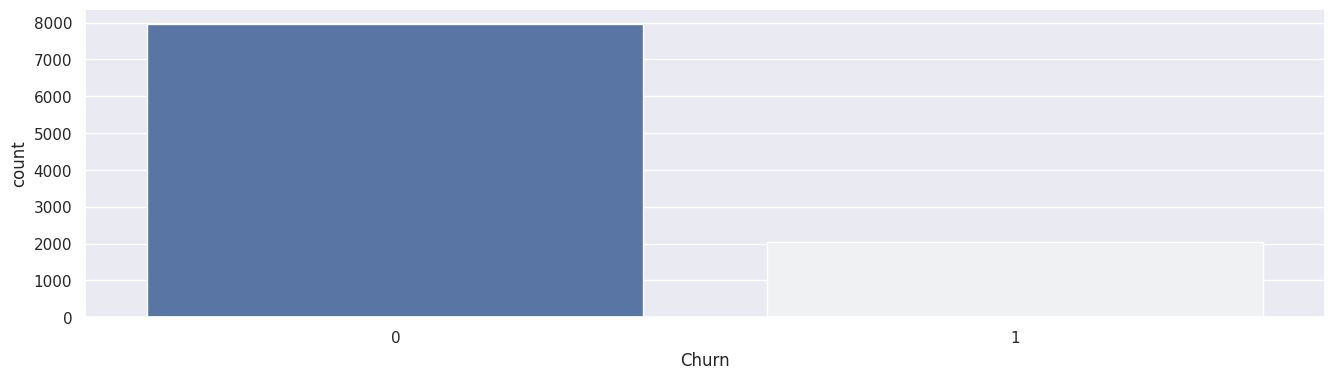

In [161]:
sns.countplot(x=df4['Churn'], palette= "light:b_r");

In [162]:
percentage_no_churn = df8[['id_cliente', 'Churn']].loc[df8['Churn'] == 0].shape[0] / df8.shape[0] * 100
percentage_yes_churn = df8[['id_cliente', 'Churn']].loc[df8['Churn'] == 1].shape[0] / df8.shape[0] * 100
print(f'R: Clientes que irão dar Churn correspondem a {percentage_yes_churn:.2f}% da base de dados e clientes que não irão dar Churn correspondem a {percentage_no_churn:.2f}% da base de dados.')

R: Clientes que irão dar Churn correspondem a 20.37% da base de dados e clientes que não irão dar Churn correspondem a 79.63% da base de dados.


## How does the churn rate vary monthly?

- Será respondido no próximo ciclo.

## What is the performance of the model in classifying customers as churns?

    R: O modelo possui uma precisão de 86% nesse segundo ciclo.

## What is the expected return, in terms of revenue, if the company uses its model to avoid churn from customers?

- Será respondido no próximo ciclo.

# Deploy

## Note:
Próxima versão: criação da classe para deploy.

# Referências

- Alura - Lidando com desbalanceamente de dados (https://www.alura.com.br/artigos/lidando-com-desbalanceamento-dados#:~:text=%C3%89%20uma%20t%C3%A9cnica%20que%20consiste%20em%20aumentar%20a%20quantidade%20de,da%20classe%20com%20menor%20frequ%C3%AAncia)
- Imbalanced Learn - Over-sampling (https://imbalanced-learn.org/stable/over_sampling.html#from-random-over-sampling-to-smote-and-adasyn)